<a href="https://colab.research.google.com/github/Santifedz/Lung_Cancer_Disparities/blob/main/Copy_of_Lung_Cancer_Disparities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![link text](https://www.wcrf.org/wp-content/webp-express/webp-images/doc-root/wp-content/uploads/2021/05/Cancer-Trends-Lung-data.png.webp)

# Lung Cancer Disparities

## Changes to our project

We have made changes to the overall problem as as well as our proposed solution. Initially, the problem that we wanted to solve was to know whether whether among middle aged adults (50+) approximately when they get diagnosed with lung cancer and whether there were disparaties based on race and gender. If there were disparaties, we also wanted to know when the most vulnerable people should seek preventative care.
As our solution to the problem we thought it best to use clustering to group people of similar demographics and exposures and discover disparties based on the results. We also decided to use regression to find a relationship between diagnosis date and relevant data such as demographics and exposures.

As we went on with our project and after our meeting with the professor, we came to realize that our main objective for the project was unclear so we decided to refine our problem statement and simplify it. As a result, we decided that we no longer wanted to know approximately when middle aged adults were diagnosed and instead, decided to just focus on whether disparities exist and if so, when the most vulnerable people should seek preventative care.

Based on the suggestions of the professor, we also modified our Machine Learning techniques by replacing Clustering with Classification so that we will be better able to predict who will be most vulnerable. We also changed our goal for regression by using it to see whether there is a relationship between race/gender and disease progression among the vulnerable.

## Data

To conduct our research project, we have collected clinical data from a sample of 2000 lung cancer patients out of a larger 12,139 patient set from the [National Cancer Institute GDC Data Portal](https://portal.gdc.cancer.gov/). When downloaded, the data is a json file that contains data objects representing each patient. For each patient, four categories of information exist. One is their case id, followed by their diagnostic, demographic, as well as follow up information.

Like most data from other areas of research, our data set included either missing, incomplete, or redundant data. For example, not all patients had a value entered for each attribute and other times, some patients did not have the same attributes at all. For that reason the data set needed extensive amounts of cleaning.

## Problem

Although cancer is a disease that affects people of all backgrouds across the United States, certain racial and ethnic groups are effected by it more severly than others. For example, According to studies done by the National Cancer Institute's [Surveillance, Epidemiology, and End Results Program](https://seer.cancer.gov/), Black/African American people had higher death rates than all other racial/ethnic groups for most cancer types. The same study also found that Hispanic and African American women had disproportionately higher rates of cervical cancer than women of other racial/ethnic groups.

Motivated by such alarming disparaties in health, we have decided to use the power of data science to help provide a solution to this problem by first identifying the most vulnerable people among racial and ethnic minorities and then be able to predict such vulnerable people so that they can seek preventative care as early as possible.


## Research Questions

Our research aims to investigate whether there is a significant association between demographic data such as race, gender and the risk factors for developing cancer. In addition, the study seeks to determine whether machine learning can be used to predict and prevent the onset of cancer in vulnerable populations.

Using regression and classification analysis, the research will develop predictive models that can identify vulnerable populations and recommend preventative care among risk groups. Exploratory data analysis will be conducted to examine the relationships between race, gender, and other demographic variables, and cancer risk factors such as smoking, alcohol consumption.

## Data Cleaning


In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

from google.colab import drive

drive.mount('/content/gdrive')

path = '/content/gdrive/MyDrive/LCData/lungCancerClinical2k.json'
#path = '/content/gdrive/MyDrive/LCData/clinical.cases_selection.2023-04-24 (1).json'

with open(path, 'r') as f:
  df = json.load(f)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data Organization

The first thing that we began doing after loading our file was to organize our data such that we had a complete set of all of the unique attributes about the patient. We made sure that there were no duplicates and if there were patients that did not have all attributes, then they were not placed. We also made sure that each attribute name was prepended with the name of the section they belonged to for convenience. Here is the code for that:

In [ ]:
unique_keys = set()

# Create a set of all unique attributes for each patient in the dataframe to avoid duplicates
for patient in df:
  if len(patient.keys()) != 5:
    continue
  if 'exposures' in patient:
    for k in patient['exposures'][0].keys():
      # add them using dot notation in case an attribute is found in two different categories
      unique_keys.add(f'exposures.{k}')
  if 'follow_ups' in patient:
    for k in patient['follow_ups'][0].keys():
      unique_keys.add(f'follow_ups.{k}')
  if 'demographic' in patient:
    for k in patient['demographic'].keys():
      unique_keys.add(f'demographic.{k}')
  if 'diagnoses' in patient:
    for k in patient['diagnoses'][0].keys():
      unique_keys.add(f'diagnoses.{k}')

# handle the edge case for the case id
unique_keys.add('case_id.')

# convert the set to list
unique_keys = list(unique_keys)


Next, we created a dictionary of patients where each patient from the original data has a list for every attribute and we populated thoes lists with appropriate data from the original dataframe. If thre were attributes that existed by name but did not exist for a paitnet in the original data frame, the entry would be added, but a value of None would be placed that way. This way, we avoided unnecessary errors due to entries that are missing entirely. This was done by:

In [ ]:
dict_of_patients = {}

# for each of the attributes create a dictonary that maps the attibute to a list of attribute information about each person
for k in unique_keys:
    dict_of_patients[k] = []

# this function fills in the dictionary
for patient in df:
  for k in unique_keys:
    subsection, attribute = k.split('.')

    # fill in the blanks with None if a person doesn't have the data (demographic, exposures, etc.)
    if subsection not in patient.keys():
       dict_of_patients[k].append(None)

    # add case_id to the dictionary
    elif subsection == 'case_id':
       dict_of_patients[k].append(patient['case_id'])
    elif subsection in ['exposures', 'follow_ups', 'diagnoses']:
      # if the attribute exists add it
       if attribute in patient[subsection][0].keys():
          dict_of_patients[k].append(patient[subsection][0][attribute])
       else:
         #else put None
         dict_of_patients[k].append(None)
    elif subsection == 'demographic':
       if attribute in patient[subsection].keys():
          # ''
          dict_of_patients[k].append(patient[subsection][attribute])
       else:
          # ''
         dict_of_patients[k].append(None)


print(len(df))

2000


Next, we converted our dictionary into a dataframe and made the patient case id attribute the index for the dataframe.

In [ ]:
df = pd.DataFrame.from_dict(dict_of_patients)
df

,diagnoses.morphology,exposures.created_datetime,exposures.submitter_id,demographic.updated_datetime,diagnoses.classification_of_tumor,diagnoses.irs_stage,diagnoses.days_to_recurrence,follow_ups.dlco_ref_predictive_percent,follow_ups.state,case_id.,...,diagnoses.ann_arbor_clinical_stage,diagnoses.submitter_id,diagnoses.enneking_msts_grade,diagnoses.days_to_best_overall_response,diagnoses.mitosis_karyorrhexis_index,demographic.premature_at_birth,demographic.year_of_birth,diagnoses.ajcc_pathologic_m,exposures.asbestos_exposure,exposures.updated_datetime
0,8070/3,None,None,2020-06-08T21:07:23.686765-05:00,None,None,NaN,NaN,None,aab0d563-9fd7-4262-9ee9-80e0c1e0245e,...,None,GENIE-NKI-L39F-GROS_diagnosis,None,NaN,None,None,NaN,None,None,None
1,8140/3,None,None,2020-06-08T21:07:23.686765-05:00,None,None,NaN,NaN,None,0df92ff8-6f47-445c-9ae9-9196a379d3fd,...,None,GENIE-NKI-KVK9-BNE3_diagnosis,None,NaN,None,None,NaN,None,None,None
2,8012/3,None,None,2020-06-08T21:07:23.686765-05:00,None,None,NaN,NaN,None,918fe25a-f7d6-433e-b600-298691821349,...,None,GENIE-NKI-PM30-W86N_diagnosis,None,NaN,None,None,NaN,None,None,None
3,8046/3,None,None,2020-06-08T21:05:18.799997-05:00,None,None,NaN,NaN,None,7cc593db-f7d5-43f4-bbe7-5009cb49c68b,...,None,GENIE-NKI-K1L4-00MM_diagnosis,None,NaN,None,None,NaN,None,None,None
4,8140/3,None,None,2020-06-08T21:07:23.686765-05:00,None,None,NaN,NaN,None,4a2e6916-7423-493e-8cdf-504dfe3fe7a9,...,None,GENIE-NKI-ODD0-4NIY_diagnosis,None,NaN,None,None,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,8140/3,None,TCGA-64-1679_exposure,2019-07-31T20:32:18.631953-05:00,not reported,None,NaN,NaN,None,81a0b2ff-a3d3-41bb-9ce6-765e6ae894af,...,None,TCGA-64-1679_diagnosis,None,NaN,None,None,1949.0,M0,None,2019-07-31T20:32:18.631953-05:00
1996,8140/3,None,TCGA-69-7980_exposure,2019-07-31T20:36:57.071666-05:00,not reported,None,NaN,NaN,None,aee86a89-0377-4080-b16c-408bfbe78687,...,None,TCGA-69-7980_diagnosis,None,NaN,None,None,1941.0,M0,None,2019-07-31T20:36:57.071666-05:00
1997,8140/3,None,TCGA-78-7145_exposure,2019-07-31T20:26:40.026511-05:00,not reported,None,NaN,NaN,None,4ef872e1-82c9-4939-9248-41ed9d3085b2,...,None,TCGA-78-7145_diagnosis,None,NaN,None,None,1948.0,M1,None,2019-07-31T20:26:40.026511-05:00
1998,8140/3,None,TCGA-O1-A52J_exposure,2019-07-31T20:25:24.258294-05:00,not reported,None,NaN,NaN,None,42432463-8e92-4f25-b72a-f03953527aa5,...,None,TCGA-O1-A52J_diagnosis,None,NaN,None,None,1933.0,MX,None,2019-07-31T20:25:24.258294-05:00


In [ ]:
by_case_id = df.set_index('case_id.')
by_case_id

,diagnoses.morphology,exposures.created_datetime,exposures.submitter_id,demographic.updated_datetime,diagnoses.classification_of_tumor,diagnoses.irs_stage,diagnoses.days_to_recurrence,follow_ups.dlco_ref_predictive_percent,follow_ups.state,follow_ups.height,...,diagnoses.ann_arbor_clinical_stage,diagnoses.submitter_id,diagnoses.enneking_msts_grade,diagnoses.days_to_best_overall_response,diagnoses.mitosis_karyorrhexis_index,demographic.premature_at_birth,demographic.year_of_birth,diagnoses.ajcc_pathologic_m,exposures.asbestos_exposure,exposures.updated_datetime
case_id.,,,,,,,,,,,,,,,,,,,,,
aab0d563-9fd7-4262-9ee9-80e0c1e0245e,8070/3,None,None,2020-06-08T21:07:23.686765-05:00,None,None,NaN,NaN,None,NaN,...,None,GENIE-NKI-L39F-GROS_diagnosis,None,NaN,None,None,NaN,None,None,None
0df92ff8-6f47-445c-9ae9-9196a379d3fd,8140/3,None,None,2020-06-08T21:07:23.686765-05:00,None,None,NaN,NaN,None,NaN,...,None,GENIE-NKI-KVK9-BNE3_diagnosis,None,NaN,None,None,NaN,None,None,None
918fe25a-f7d6-433e-b600-298691821349,8012/3,None,None,2020-06-08T21:07:23.686765-05:00,None,None,NaN,NaN,None,NaN,...,None,GENIE-NKI-PM30-W86N_diagnosis,None,NaN,None,None,NaN,None,None,None
7cc593db-f7d5-43f4-bbe7-5009cb49c68b,8046/3,None,None,2020-06-08T21:05:18.799997-05:00,None,None,NaN,NaN,None,NaN,...,None,GENIE-NKI-K1L4-00MM_diagnosis,None,NaN,None,None,NaN,None,None,None
4a2e6916-7423-493e-8cdf-504dfe3fe7a9,8140/3,None,None,2020-06-08T21:07:23.686765-05:00,None,None,NaN,NaN,None,NaN,...,None,GENIE-NKI-ODD0-4NIY_diagnosis,None,NaN,None,None,NaN,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81a0b2ff-a3d3-41bb-9ce6-765e6ae894af,8140/3,None,TCGA-64-1679_exposure,2019-07-31T20:32:18.631953-05:00,not reported,None,NaN,NaN,None,NaN,...,None,TCGA-64-1679_diagnosis,None,NaN,None,None,1949.0,M0,None,2019-07-31T20:32:18.631953-05:00
aee86a89-0377-4080-b16c-408bfbe78687,8140/3,None,TCGA-69-7980_exposure,2019-07-31T20:36:57.071666-05:00,not reported,None,NaN,NaN,None,NaN,...,None,TCGA-69-7980_diagnosis,None,NaN,None,None,1941.0,M0,None,2019-07-31T20:36:57.071666-05:00
4ef872e1-82c9-4939-9248-41ed9d3085b2,8140/3,None,TCGA-78-7145_exposure,2019-07-31T20:26:40.026511-05:00,not reported,None,NaN,NaN,None,NaN,...,None,TCGA-78-7145_diagnosis,None,NaN,None,None,1948.0,M1,None,2019-07-31T20:26:40.026511-05:00


Next, we decided that the most valuable attributes for our purposes were the ones under the catergory of Exposures and Demographics. Exposures were the list of attributes that increase the risk of lung cancer such as smoking and drinking alcohol which would help us determine whehther (needs work). Demographics referred to the information such as race, gender, age, etc that would be used to find correlations in disease. Here is how we cleaned the Demographics and Exposures tables:

### Demographics

*By Sharon Thomeh*

For this portion, we first took the organized data frame we just made and filtered it by only finding patients who had their demographic information, case id, and the pathological stage of their disease. The pathological stage would help us observe the progression of disease and compare it between different racial groups.

In [ ]:
demographic_df = by_case_id.filter(regex='^demographic|case_id|diagnoses.ajcc_pathologic_stage')

demographic_df.head()

,demographic.updated_datetime,demographic.vital_status,demographic.ethnicity,demographic.created_datetime,demographic.days_to_death,diagnoses.ajcc_pathologic_stage,demographic.gender,demographic.age_at_index,demographic.days_to_birth,demographic.year_of_death,demographic.demographic_id,demographic.weeks_gestation_at_birth,demographic.submitter_id,demographic.race,demographic.cause_of_death,demographic.state,demographic.premature_at_birth,demographic.year_of_birth
case_id.,,,,,,,,,,,,,,,,,,
aab0d563-9fd7-4262-9ee9-80e0c1e0245e,2020-06-08T21:07:23.686765-05:00,Not Reported,Unknown,2019-05-29T19:43:03.186932-05:00,NaN,None,female,21184.0,-21184.0,NaN,2caec1bf-f269-4622-a0fc-d8885bc88674,None,GENIE-NKI-L39F_demo,Unknown,None,released,None,NaN
0df92ff8-6f47-445c-9ae9-9196a379d3fd,2020-06-08T21:07:23.686765-05:00,Not Reported,Unknown,2018-10-02T17:46:20.458890-05:00,NaN,None,male,27759.0,-27759.0,NaN,5c48b447-b639-46ea-8621-038164d888f3,None,GENIE-NKI-KVK9_demo,Unknown,None,released,None,NaN
918fe25a-f7d6-433e-b600-298691821349,2020-06-08T21:07:23.686765-05:00,Not Reported,Unknown,2018-10-02T17:46:20.458890-05:00,NaN,None,female,16801.0,-16801.0,NaN,2aa422df-1cd1-42bd-8459-938afa5f7ba1,None,GENIE-NKI-PM30_demo,Unknown,None,released,None,NaN
7cc593db-f7d5-43f4-bbe7-5009cb49c68b,2020-06-08T21:05:18.799997-05:00,Not Reported,Unknown,2018-10-02T17:46:20.458890-05:00,NaN,None,male,14975.0,-14975.0,NaN,ee9684a1-0852-4cb0-941b-1960364910dd,None,GENIE-NKI-K1L4_demo,Unknown,None,released,None,NaN
4a2e6916-7423-493e-8cdf-504dfe3fe7a9,2020-06-08T21:07:23.686765-05:00,Not Reported,Unknown,2018-10-02T17:46:20.458890-05:00,NaN,None,female,23376.0,-23376.0,NaN,6f8435fd-ea6e-4ebb-a406-90fafef9a81e,None,GENIE-NKI-ODD0_demo,Unknown,None,released,None,NaN


Here was the size of the data before any cleaning has taken place:

In [ ]:
demographic_df.shape

(2000, 18)

Next, we checked how many of each column in the demographics table has missing values so we have an idea of what we can clean:

In [ ]:
demographic_df.isna().sum()

demographic.updated_datetime               0
demographic.vital_status                   0
demographic.ethnicity                      0
demographic.created_datetime             993
demographic.days_to_death               1525
diagnoses.ajcc_pathologic_stage          628
demographic.gender                         0
demographic.age_at_index                 587
demographic.days_to_birth                262
demographic.year_of_death               1642
demographic.demographic_id                 0
demographic.weeks_gestation_at_birth    2000
demographic.submitter_id                   0
demographic.race                           0
demographic.cause_of_death              1928
demographic.state                          0
demographic.premature_at_birth          2000
demographic.year_of_birth                658
dtype: int64

Next, we futher filtered the dataframe by keeping only the most relavent attributes such as gender, race, ethinicity, etc, dropped patients that did not have their pathologically stage stated, and placed zeros in numeric columns with missing information.

In [ ]:
demographic_clean = demographic_df[['demographic.gender','demographic.race', 'demographic.days_to_death', 'demographic.year_of_birth', 'demographic.days_to_birth','demographic.state','diagnoses.ajcc_pathologic_stage', 'demographic.vital_status','demographic.ethnicity']]

demographic_clean = demographic_clean.dropna(subset = ['diagnoses.ajcc_pathologic_stage'])

demographic_clean['demographic.days_to_birth'] = demographic_clean['demographic.days_to_birth'].fillna(value=0)
demographic_clean['demographic.year_of_birth'] = demographic_clean['demographic.year_of_birth'].fillna(value=0)


Then, we took people who's vital status was currently Alive and replaced the column for the days before death as zero. We then dropped the ones for which days to death was missing, removed ones who race was unknown, and ones for whom no year of birth was entered.

In [ ]:
alive_mask = demographic_clean['demographic.vital_status'] == 'Alive'

demographic_clean.loc[alive_mask, ['demographic.days_to_death']] = 0

demographic_clean = demographic_clean.dropna(subset = ['demographic.days_to_death'])

demographic_clean = demographic_clean[demographic_clean['demographic.race'] != 'Unknown']

demographic_clean = demographic_clean[demographic_clean['demographic.year_of_birth'] != 0]

demographic_clean.isna().sum()

demographic.gender                 0
demographic.race                   0
demographic.days_to_death          0
demographic.year_of_birth          0
demographic.days_to_birth          0
demographic.state                  0
diagnoses.ajcc_pathologic_stage    0
demographic.vital_status           0
demographic.ethnicity              0
dtype: int64

Now that cleaning is done, we have the final size of the table which is

In [ ]:
demographic_clean.shape

(1293, 9)

### Exposures Table

*By Santiago Fernandez*

The database included a wide variety of information pertaining to different patients and research studies, we filtered the data in order to keep the relevant risk factor or lack thereof that each patient was exposed to in their lifetime and created an *Exposures* table to represent this.

In [ ]:
# use filter to keep columns that start with 'exposures' or contains case_id
exposures_df = by_case_id.filter(regex='^exposures|case_id|follow_ups.bmi|follow_ups.weight|follow_ups.height|follow_ups.comorbidity|follow_ups.state')
#keeping the most relevant data
exposures_clean = exposures_df[['exposures.alcohol_intensity', 'follow_ups.bmi', 'follow_ups.height',  'exposures.state', 'exposures.years_smoked', 'follow_ups.weight', 'exposures.alcohol_history', 'exposures.pack_years_smoked', 'exposures.cigarettes_per_day' ]]
exposures_clean.isna().sum()

exposures.alcohol_intensity     1671
follow_ups.bmi                  1672
follow_ups.height               1671
exposures.state                  625
exposures.years_smoked          1382
follow_ups.weight               1671
exposures.alcohol_history        629
exposures.pack_years_smoked     1019
exposures.cigarettes_per_day     999
dtype: int64

We now have to clean the exposures table in order to account for any missing or non applicable data that has been carried over.

First, we must drop the patients in exposures that we do not contain demographics data for:

In [ ]:
demo_id = set(demographic_clean.index)

exp_id = set(exposures_clean.index)

exp_patients = demo_id.intersection(exp_id)

exposures_clean = exposures_clean.loc[exp_patients]

exposures_clean.isna().sum()

<ipython-input-124-f3b3c8399822>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  exposures_clean = exposures_clean.loc[exp_patients]


exposures.alcohol_intensity     987
follow_ups.bmi                  987
follow_ups.height               986
exposures.state                   2
exposures.years_smoked          707
follow_ups.weight               986
exposures.alcohol_history         5
exposures.pack_years_smoked     364
exposures.cigarettes_per_day    345
dtype: int64

Now, If the patient did not smoke, then this should be represented in the smoking related exposures. Similarly, this will also be applied to alcohol use.

In [ ]:
# TABACCO:
# if the patient has 0 years smoked their pack years should be 0 and vice versa
rows_with_zero_pack_years = exposures_clean.loc[exposures_clean['exposures.pack_years_smoked'] == 0]
exposures_clean.loc[rows_with_zero_pack_years.index, 'exposures.years_smoked'] = 0
exposures_clean.loc[rows_with_zero_pack_years.index, 'exposures.cigarettes_per_day'] = 0

rows_with_zero_years_smoked = exposures_clean.loc[exposures_clean['exposures.years_smoked'] == 0]
exposures_clean.loc[rows_with_zero_years_smoked.index, 'exposures.pack_years_smoked'] = 0
exposures_clean.loc[rows_with_zero_years_smoked.index, 'exposures.cigarettes_per_day'] = 0


rows_with_zero_cigarettes = exposures_clean.loc[exposures_clean['exposures.cigarettes_per_day'] == 0]
exposures_clean.loc[rows_with_zero_cigarettes.index, 'exposures.years_smoked'] = 0
exposures_clean.loc[rows_with_zero_cigarettes.index, 'exposures.pack_years_smoked'] = 0

# we can populate the years smoked with the pack years smoked for an individual
# pack_years = (number_of_packs_per_day * number_of_years_smoked) / 20
missing_years_smoked = exposures_clean['exposures.years_smoked'].isna() | (exposures_clean['exposures.years_smoked'] == 0)
# Calculate the value for 'years_smoked'
calculated_years_smoked = (exposures_clean['exposures.pack_years_smoked']*20) / (exposures_clean['exposures.cigarettes_per_day'] * 365)
exposures_clean.loc[missing_years_smoked, 'exposures.years_smoked'] = calculated_years_smoked[missing_years_smoked]

#the remaining tabacco nan must be dropped
exposures_clean = exposures_clean.dropna(subset = ['exposures.years_smoked'])

average_pack_years = exposures_clean['exposures.pack_years_smoked'].mean()
exposures_clean['exposures.pack_years_smoked'].fillna(value=average_pack_years, inplace=True)

average_pack_years = exposures_clean['exposures.cigarettes_per_day'].mean()
exposures_clean['exposures.cigarettes_per_day'].fillna(value=average_pack_years, inplace=True)

At this point we have much more tabacco exposure data than alcohol and bmi. In order to keep as much relevant information as possible, we can fill the NaN data in alcohol and bmi to be an indicator value that will allow us to keep certain collumns that are relevant for tabacco.

In [ ]:
exposures_clean.isna().sum()

exposures.alcohol_intensity     774
follow_ups.bmi                  774
follow_ups.height               774
exposures.state                   0
exposures.years_smoked            0
follow_ups.weight               774
exposures.alcohol_history         0
exposures.pack_years_smoked       0
exposures.cigarettes_per_day      0
dtype: int64

In [ ]:
follow_ups_df = exposures_clean[['follow_ups.bmi', 'follow_ups.height', 'follow_ups.weight']]

exposures_clean['exposures.alcohol_intensity'].fillna(value='Unknown', inplace=True)
exposures_clean['follow_ups.bmi'].fillna(value='N/A', inplace=True)
exposures_clean['follow_ups.height'].fillna(value='N/A', inplace=True)
exposures_clean['follow_ups.weight'].fillna(value='N/A', inplace=True)

In [ ]:
exposures_clean.isna().sum() # all clean

exposures.alcohol_intensity     0
follow_ups.bmi                  0
follow_ups.height               0
exposures.state                 0
exposures.years_smoked          0
follow_ups.weight               0
exposures.alcohol_history       0
exposures.pack_years_smoked     0
exposures.cigarettes_per_day    0
dtype: int64

#Exploratory Data Analysis and Visualizations

After cleaning, we began to explore and analyze each of our data tables by observering their each column and looked for interesting relationships between each patients's attributes in the following way:


## Demographics

*By Sharon Thomeh*

For demographic information, we began by looking at the size of the data table:

In [ ]:
demographic_clean.shape

(1293, 9)

Next, we looked at some basic descriptive statistics:

In [ ]:
demographic_clean.describe()

,demographic.days_to_death,demographic.year_of_birth,demographic.days_to_birth
count,1293.000000,1293.000000,1293.000000
mean,281.941995,1944.195669,-23957.348028
std,582.327882,11.128767,4066.242167
min,-1.000000,1915.000000,-32872.000000
25%,0.000000,1936.000000,-26682.000000
50%,0.000000,1944.000000,-24477.000000
75%,334.000000,1952.000000,-21834.000000
max,5287.000000,1980.000000,0.000000


Next, we looked at each demographic attribute separately to see what their value count were their statistical data type, as well as some descriptive statistics such as central tendency and dispersion:

### Gender Column

Statistical Data Type: Nominal because they are categorical

In [ ]:
gender_counts = demographic_clean['demographic.gender'].value_counts()

print(gender_counts)


male      808
female    485
Name: demographic.gender, dtype: int64


Central Tendency





In [ ]:
gender_mode = demographic_clean['demographic.gender'].mode()
gender_mode

0    male
Name: demographic.gender, dtype: object

Measure of Dispersion




In [ ]:
total_gender = len(demographic_clean['demographic.gender'])
total_mode_gender = (demographic_clean['demographic.gender'] == "male").sum()
dispersion_gender = 1 - (total_mode_gender/total_gender)
dispersion_gender

0.37509667440061867

<Axes: >

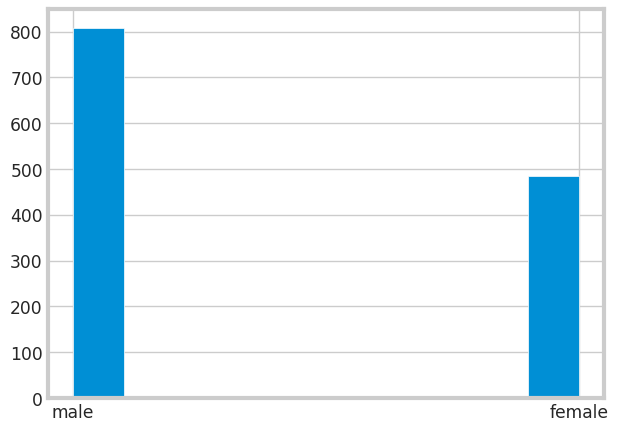

In [ ]:
demographic_clean["demographic.gender"].hist()

In [ ]:
demographic_clean['demographic.gender'].describe()

count     1293
unique       2
top       male
freq       808
Name: demographic.gender, dtype: object

### Race Column

Statistical Data type: Nominal because these are categorical



In [ ]:
# getting some numbers about the number of races
race_counts = demographic_clean['demographic.race'].value_counts()

print(race_counts)

white                               842
not reported                        345
black or african american            83
asian                                21
american indian or alaska native      2
Name: demographic.race, dtype: int64


Central Tendency



In [ ]:
race_mode = demographic_clean['demographic.race'].mode()
race_mode

0    white
Name: demographic.race, dtype: object

Measure of Dispersion



In [ ]:
total_race = len(demographic_clean['demographic.race'])
total_mode_race = (demographic_clean['demographic.race'] == "white").sum()
dispersion_race = 1 - (total_mode_race/total_race)
dispersion_race

0.34880123743232794

<Axes: >

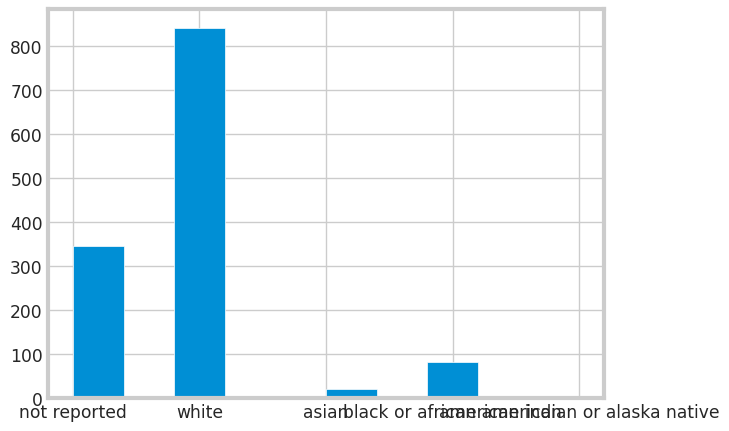

In [ ]:
demographic_clean["demographic.race"].hist()

### Days to Death Column

Statistical Data type: Ratio it is a duration of time

Central Tendency


In [ ]:
days_to_death_mean = demographic_clean['demographic.days_to_death'].mean()
days_to_death_mean

281.9419953596288

In [ ]:
unique_yob = demographic_clean['demographic.year_of_birth'].unique()
unique_yob

array([1955., 1963., 1956., 1951., 1962., 1979., 1940., 1968., 1944.,
       1958., 1954., 1965., 1959., 1964., 1935., 1948., 1957., 1961.,
       1947., 1953., 1945., 1952., 1950., 1946., 1949., 1939., 1966.,
       1960., 1941., 1928., 1943., 1973., 1970., 1942., 1938., 1969.,
       1971., 1967., 1980., 1972., 1976., 1936., 1974., 1934., 1931.,
       1929., 1923., 1933., 1925., 1927., 1937., 1930., 1932., 1924.,
       1920., 1922., 1921., 1918., 1926., 1915., 1916.])

Measure of Dispersion

In [ ]:
days_to_death_std = demographic_clean['demographic.days_to_death'].std()
days_to_death_std

582.3278819640475

<Axes: >

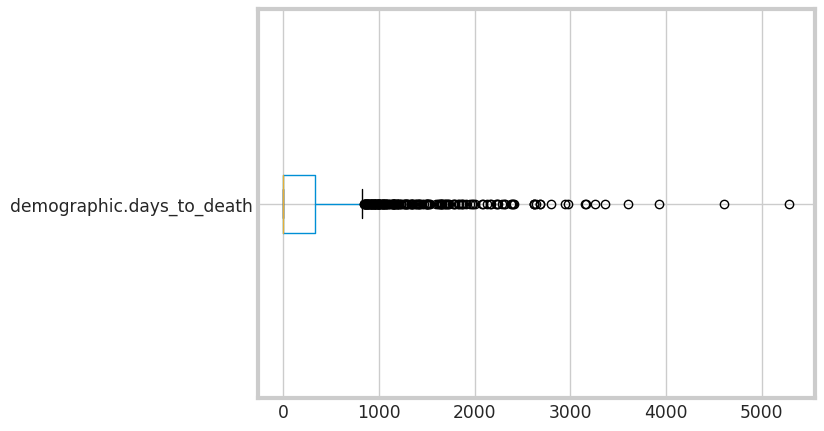

In [ ]:
demographic_clean.boxplot(column='demographic.days_to_death', vert=False)

In [ ]:
demographic_clean["demographic.days_to_death"].describe()

count    1293.000000
mean      281.941995
std       582.327882
min        -1.000000
25%         0.000000
50%         0.000000
75%       334.000000
max      5287.000000
Name: demographic.days_to_death, dtype: float64

### Year of Birth Column

Statistical Data type: Interval because it has no true zero value

Central Tendency

In [ ]:
year_of_birth_mean = demographic_clean['demographic.year_of_birth'].mean()
year_of_birth_mean

1944.1956689868523

Measure of Dispersion

In [ ]:
year_of_birth_std = demographic_clean['demographic.year_of_birth'].std()
year_of_birth_std

11.128766998729791

<Axes: >

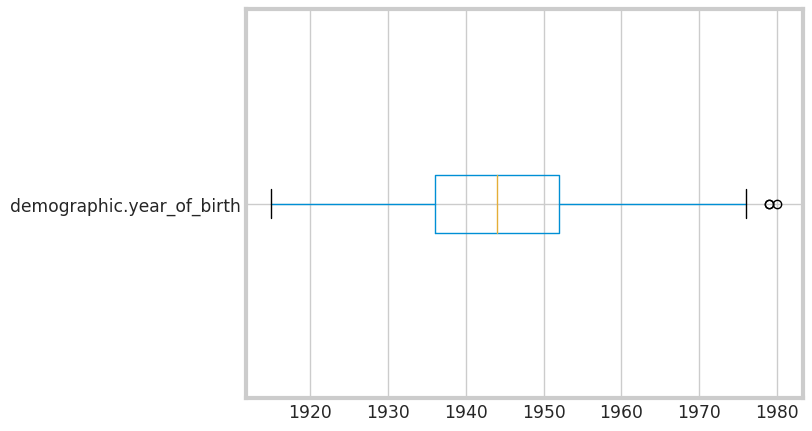

In [ ]:
demographic_clean.boxplot(column='demographic.year_of_birth', vert=False)

In [ ]:
demographic_clean["demographic.year_of_birth"].describe()

count    1293.000000
mean     1944.195669
std        11.128767
min      1915.000000
25%      1936.000000
50%      1944.000000
75%      1952.000000
max      1980.000000
Name: demographic.year_of_birth, dtype: float64

### Days to Birth Column

Statistical Data type: Ratio because it is a duration of time

Central Tendency



In [ ]:
days_to_birth_mean = demographic_clean['demographic.days_to_birth'].mean()
days_to_birth_mean

-23957.34802784223

Measure of Dispersion

In [ ]:
days_to_birth_std = demographic_clean['demographic.days_to_birth'].std()
days_to_birth_std

4066.2421673214444

<Axes: >

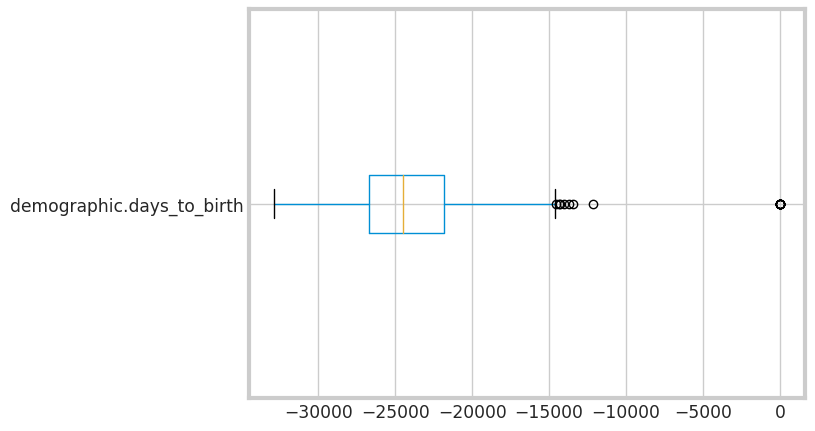

In [ ]:
demographic_clean.boxplot(column='demographic.days_to_birth', vert=False)

In [ ]:
demographic_clean['demographic.days_to_birth'].describe()

count     1293.000000
mean    -23957.348028
std       4066.242167
min     -32872.000000
25%     -26682.000000
50%     -24477.000000
75%     -21834.000000
max          0.000000
Name: demographic.days_to_birth, dtype: float64

### State Column

Statistical Data type: Nominal because it is descriptive

In [ ]:
state_counts = demographic_clean['demographic.state'].value_counts()

print(state_counts)

released    1293
Name: demographic.state, dtype: int64


*All of the patients are released so there is no need for central tendency or Measure of dispersion

<Axes: >

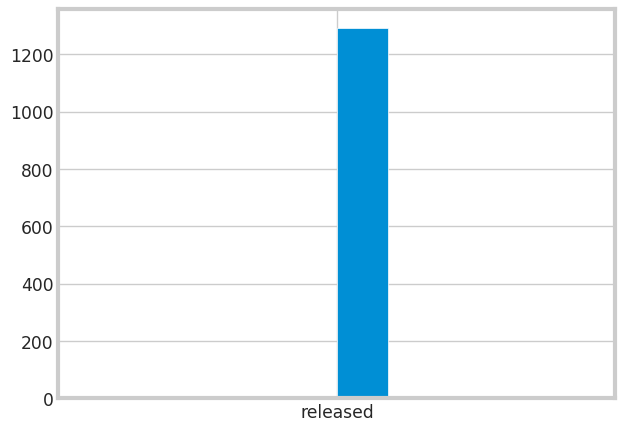

In [ ]:
demographic_clean["demographic.state"].hist()

In [ ]:
demographic_clean["demographic.state"].describe()

count         1293
unique           1
top       released
freq          1293
Name: demographic.state, dtype: object

### ajcc pathologic stage Column

Statistical Data type: Ordinal because it is based on how advanced the disease is

In [ ]:
ajcc_pathologic_stage_counts = demographic_clean['diagnoses.ajcc_pathologic_stage'].value_counts()
print(ajcc_pathologic_stage_counts)

Stage IB        356
Stage IA        266
Stage IIIA      194
Stage IIB       194
Stage IIA       166
Stage IV         41
Stage IIIB       33
Stage I          20
Stage II          8
Stage III         7
Stage IA3         5
Not Reported      2
Stage IA2         1
Name: diagnoses.ajcc_pathologic_stage, dtype: int64


Central Tendency

In [ ]:
scale = {"Not Reported":0, "Stage I":1, "Stage IA":2, "Stage IA2":3, "Stage IA3":4, "Stage IB":5, "Stage IC":5 ,"Stage II":6, "Stage IIA":6, "Stage IIB":7, "Stage III":8, "Stage IIIA":9, "Stage IIIB":10, "Stage IV":11}
demographic_clean['diagnoses.ajcc_pathologic_stage'] = demographic_clean['diagnoses.ajcc_pathologic_stage'].replace(scale)
demographic_clean['diagnoses.ajcc_pathologic_stage'].value_counts()


5     356
2     266
9     194
7     194
6     174
11     41
10     33
1      20
8       7
4       5
0       2
3       1
Name: diagnoses.ajcc_pathologic_stage, dtype: int64

In [ ]:
demographic_clean['diagnoses.ajcc_pathologic_stage'].median()

5.0

Measure of Dispersion

In [ ]:
# ???

<Axes: >

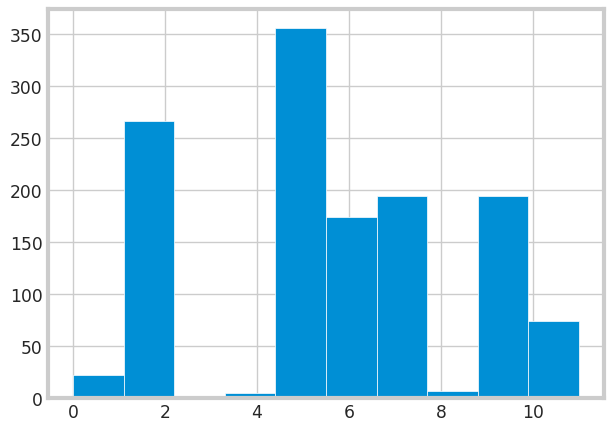

In [ ]:
demographic_clean['diagnoses.ajcc_pathologic_stage'].hist()

In [ ]:
demographic_clean['diagnoses.ajcc_pathologic_stage'].describe()

count    1293.000000
mean        5.676721
std         2.579820
min         0.000000
25%         5.000000
50%         5.000000
75%         7.000000
max        11.000000
Name: diagnoses.ajcc_pathologic_stage, dtype: float64

### Ethnicity Column

Statistical Data type: Nominal because these are categorical

In [ ]:
# getting some numbers about how many people are/are not hispanic
ethnicity_counts = demographic_clean['demographic.ethnicity'].value_counts()
print(ethnicity_counts)

not hispanic or latino    811
not reported              466
hispanic or latino         16
Name: demographic.ethnicity, dtype: int64


Central Tendency

In [ ]:
ethnicity_mode = demographic_clean['demographic.ethnicity'].mode()
ethnicity_mode

0    not hispanic or latino
Name: demographic.ethnicity, dtype: object

Measure of Dispersion

In [ ]:
total_ethnicity = len(demographic_clean['demographic.ethnicity'])
total_mode_ethnicity = (demographic_clean['demographic.ethnicity'] == "not hispanic or latino").sum()
dispersion_ethnicity = 1 - (total_mode_ethnicity/total_ethnicity)
dispersion_ethnicity

0.3727764887857695

<Axes: >

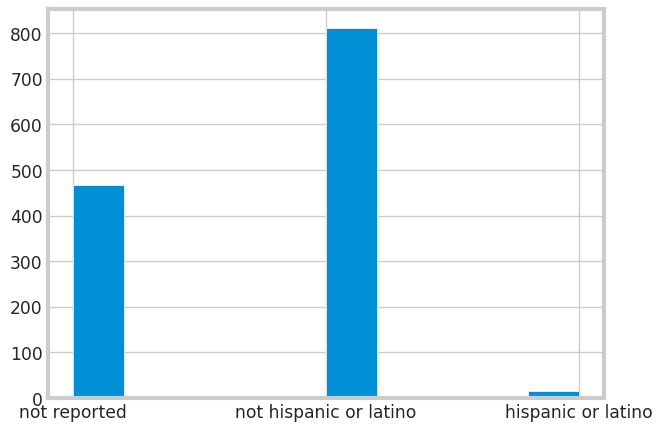

In [ ]:
demographic_clean['demographic.ethnicity'].hist()

In [ ]:
demographic_clean['demographic.ethnicity'].describe()

count                       1293
unique                         3
top       not hispanic or latino
freq                         811
Name: demographic.ethnicity, dtype: object

### Vital Status Column

Statistical Data Type: Nominal and Binary

In [ ]:
vital_counts = demographic_clean['demographic.vital_status'].value_counts()

print(vital_counts)


Alive    828
Dead     465
Name: demographic.vital_status, dtype: int64


Central Tendency

In [ ]:
vital_status_mode = demographic_clean['demographic.vital_status'].mode()
vital_status_mode

0    Alive
Name: demographic.vital_status, dtype: object

Measure of Dispersion

In [ ]:
total_vital_status = len(demographic_clean['demographic.vital_status'])
total_mode_vital_status = (demographic_clean['demographic.vital_status'] == "Alive").sum()
dispersion_vital_status = 1 - (total_mode_vital_status/total_vital_status)
dispersion_vital_status

0.3596287703016241

<Axes: >

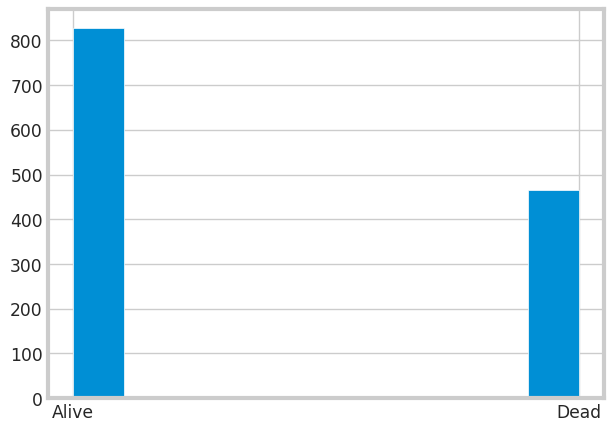

In [ ]:
demographic_clean['demographic.vital_status'].hist()

In [ ]:
demographic_clean['demographic.vital_status'].describe()

count      1293
unique        2
top       Alive
freq        828
Name: demographic.vital_status, dtype: object

### Correlations

In terms of demographics, the hypothesis that we planned to test was the fact that white lung cancer patients were more likely to survive and had better health outcomes. We believe that this hypothesis was interesting because it helps us answer arrive at the solution to our problem so that we are then able to identify and predict individuals who may be at a disadvantage compared to their white counterparts.

We began by taking all the people who had died and compared the number of days they lived before death to different attributes such as race, ethnicity and gender.

#### Figure 1

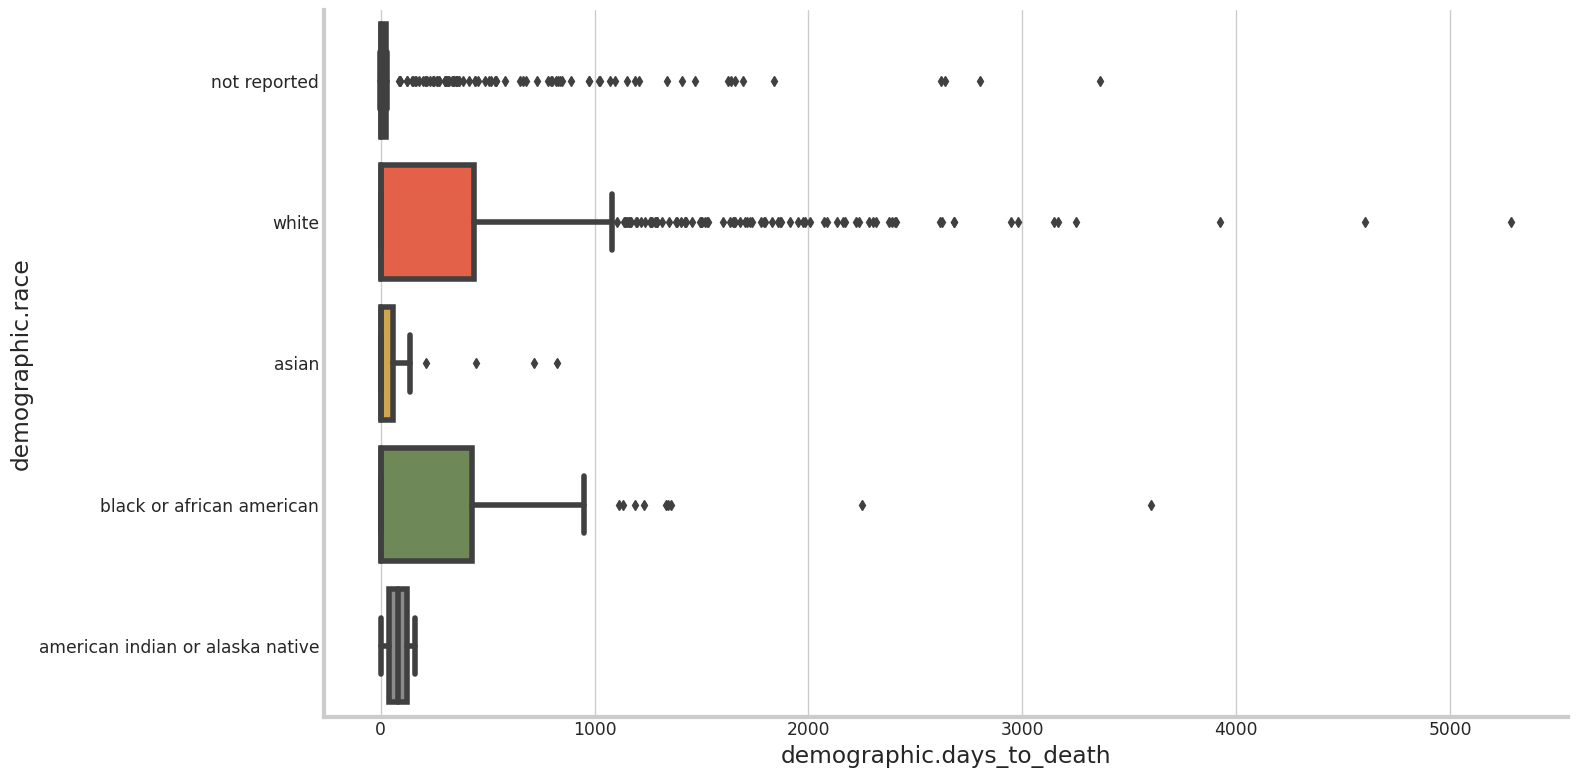

In [ ]:
sns.catplot(data=demographic_clean, x="demographic.days_to_death", y="demographic.race", kind="box", aspect=2, height=8)

#### Figure 2

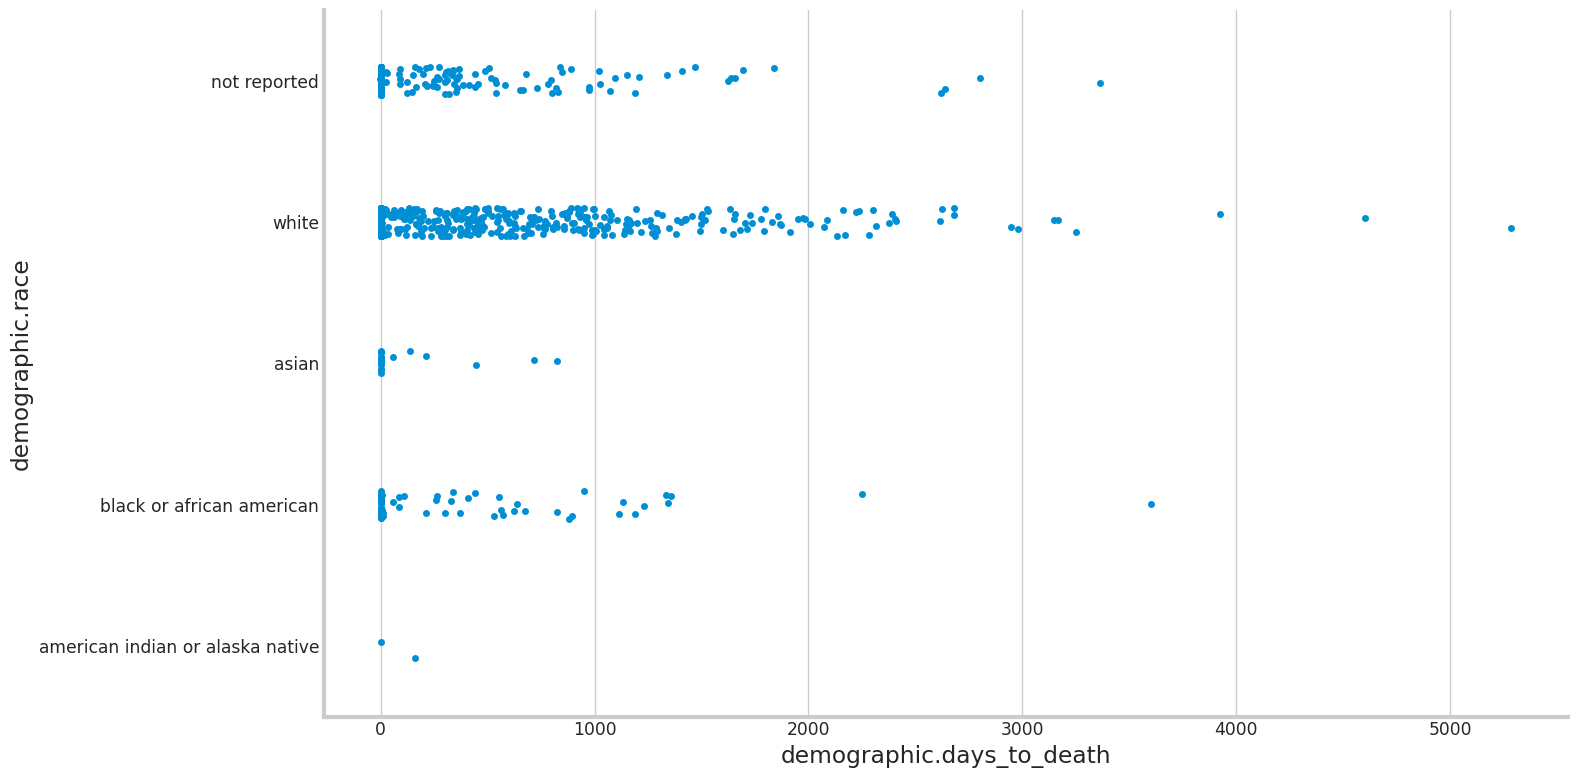

In [ ]:
sns.catplot(data=demographic_clean, x="demographic.days_to_death", y="demographic.race", aspect=2, height=8)

When observing the relationship between days till death and race, we found that Asian, Black and African American, and American Indian or Alaska Natives were severely underrepresented in the data as there were not enough people who were reported to belong to thoes races. This pattern is more apparent in Figure 2 than in Figure 1. We also noticed that white people had a much wider range of outliers. In other words, white people lived longer days before they died compared to non-whites. This suggested that the chances of survival for non-whites was non-existent. Another problem was the existence of people who had not reported their race. This made the state of people of color more difficult to determine.

#### Figure 3

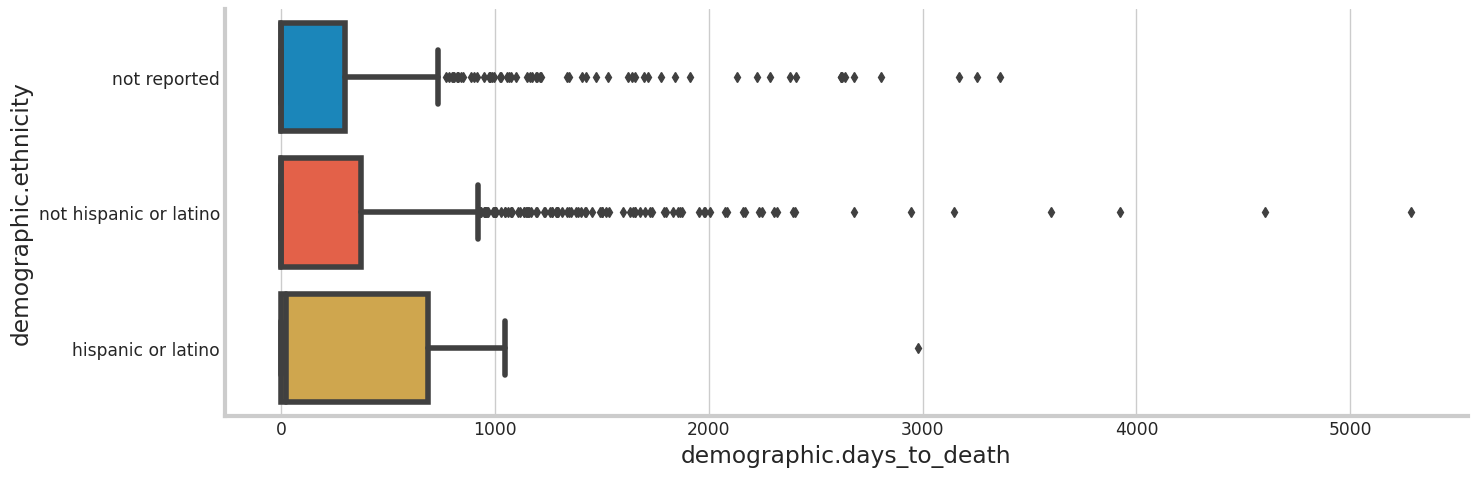

In [ ]:
sns.catplot(data=demographic_clean, x="demographic.days_to_death", y="demographic.ethnicity", aspect=3, height=5, kind="box")

#### Figure 4

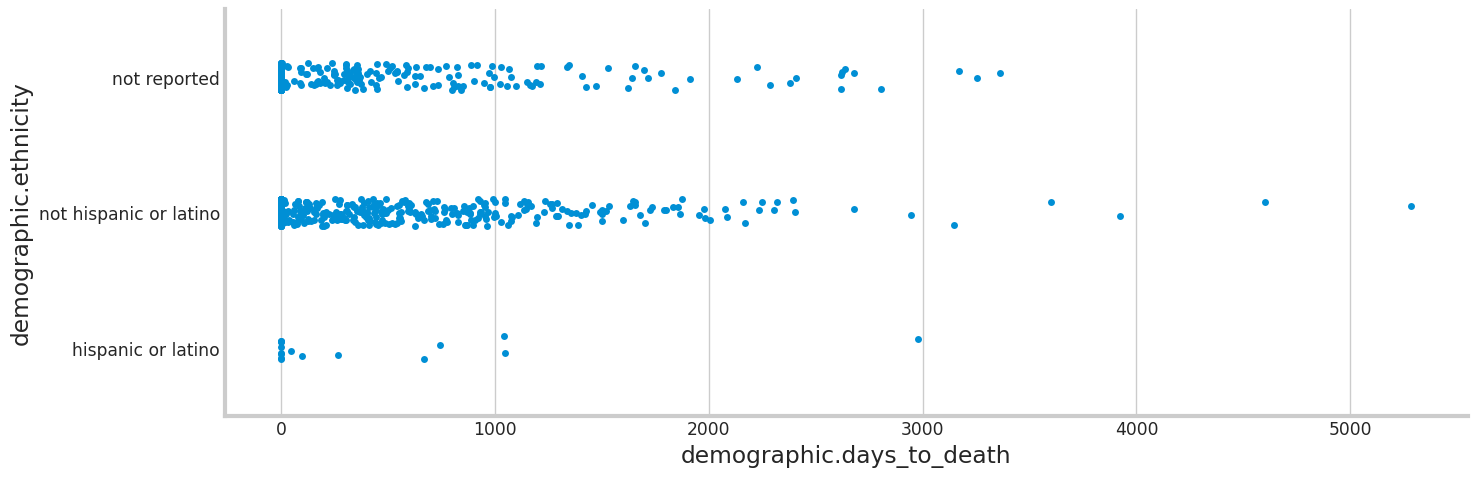

In [ ]:
sns.catplot(data=demographic_clean, x="demographic.days_to_death", y="demographic.ethnicity", aspect=3, height=5)

Next, we compared the days to death with ethnicity. Looking at Figures 3 and 4, we see that once again, hispanic/latino were an underrepresented group from the few people who were reported to belong to that group, no one lived longer than 3000 days. However among whites there were more outliners that lived past 5000 days. There was also a fairly large number of people who's ethnicity was not reported, thus futher complicating the issue.

#### Figure 5

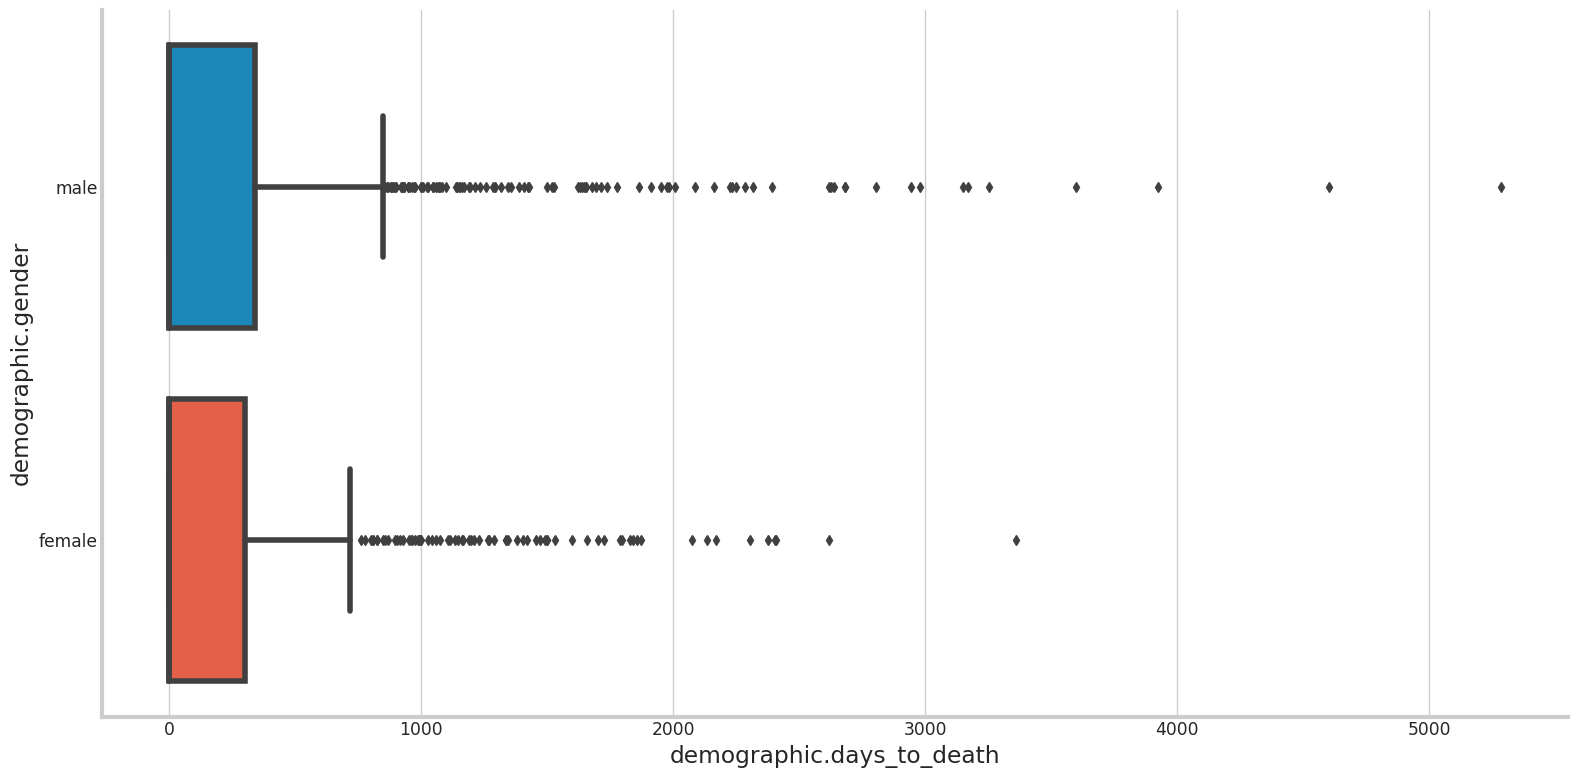

In [ ]:
sns.catplot(data=demographic_clean, x="demographic.days_to_death", y="demographic.gender", kind = 'box', aspect=2, height=8)

#### Figure 6

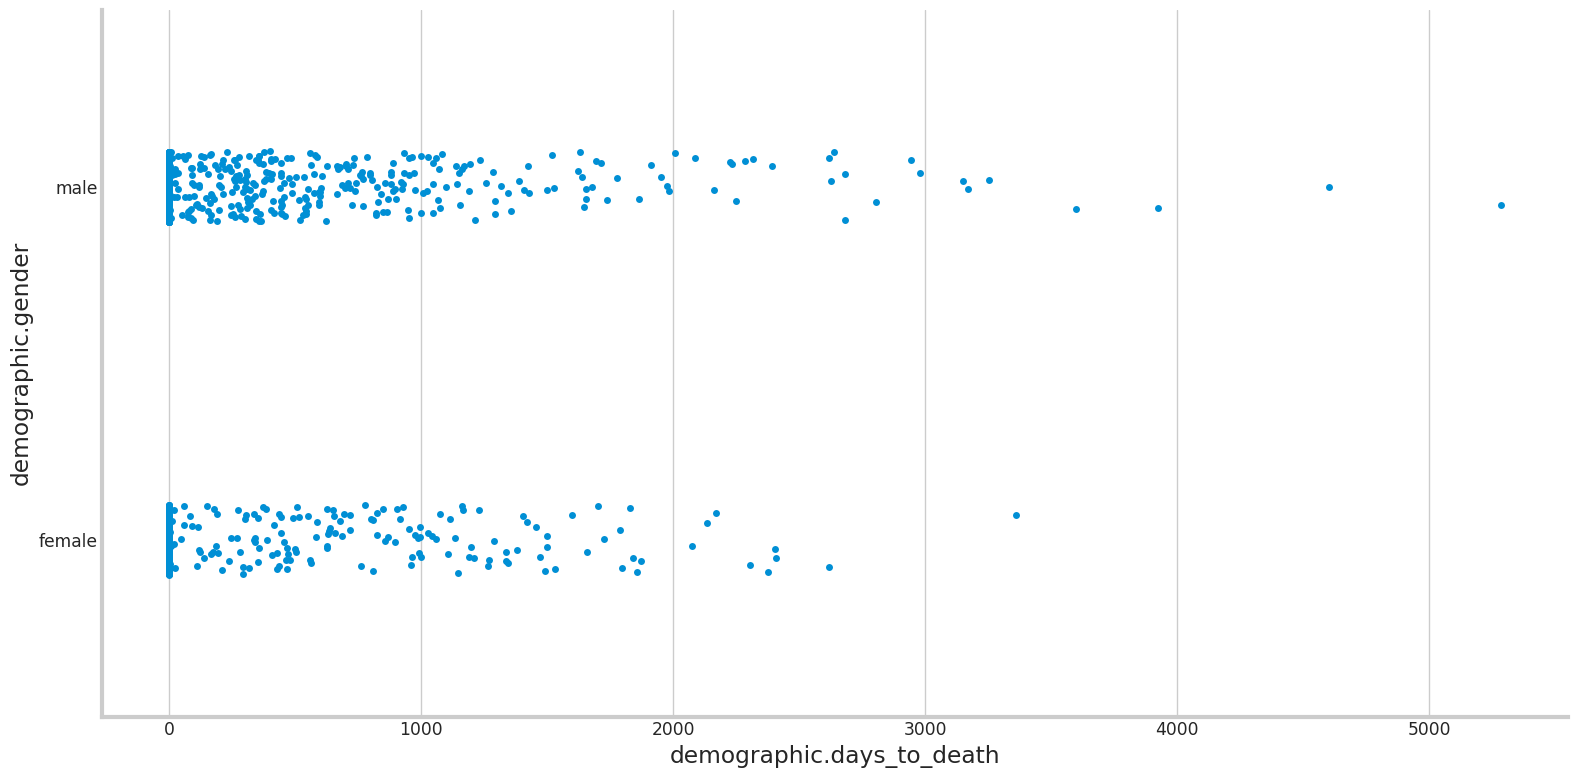

In [ ]:
sns.catplot(data=demographic_clean, x="demographic.days_to_death", y="demographic.gender", aspect=2, height=8)

#### Figure 7

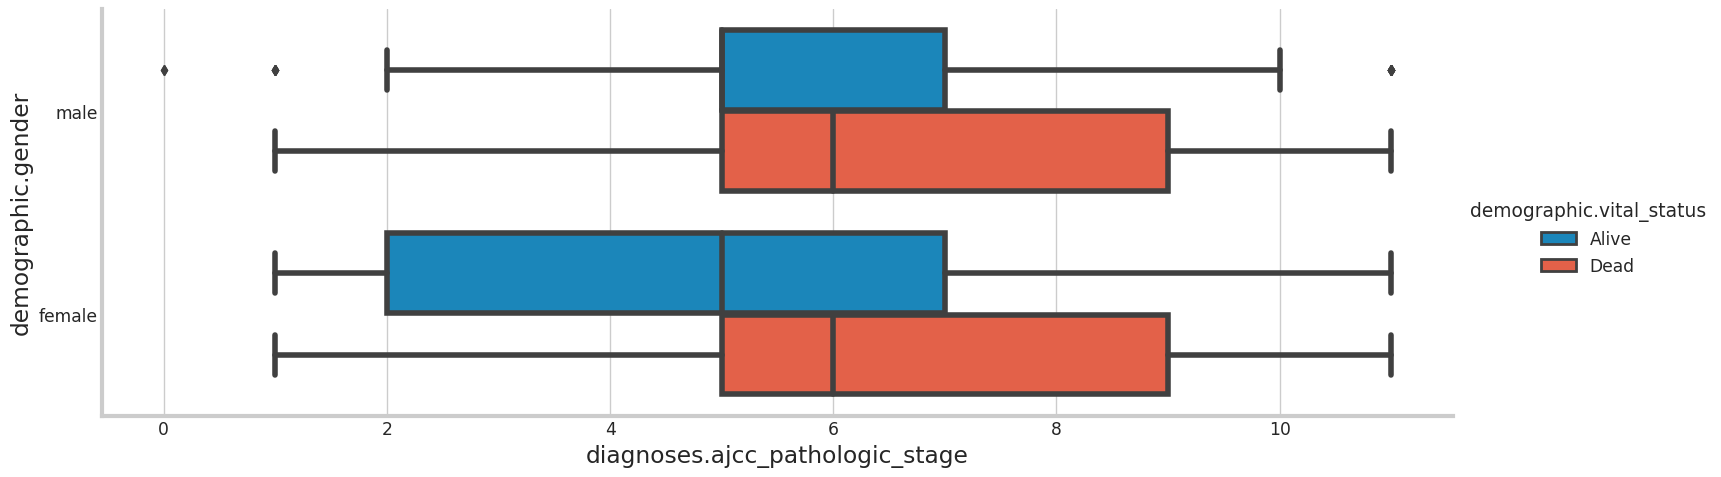

In [ ]:
sns.catplot(data=demographic_clean, x="diagnoses.ajcc_pathologic_stage", y="demographic.gender", kind="box", aspect=3, height=5, hue="demographic.vital_status")
# there are more women at earlier stages than men who are alive

#### Figure 8

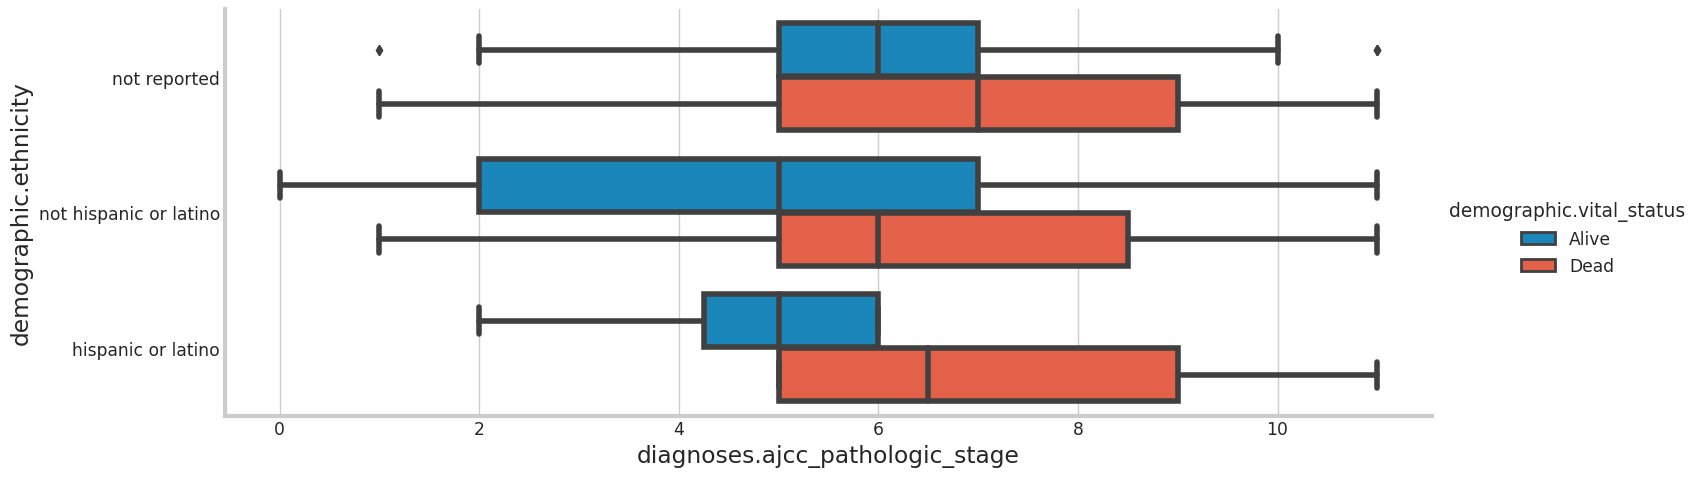

In [ ]:
sns.catplot(data=demographic_clean, x="diagnoses.ajcc_pathologic_stage", y="demographic.ethnicity", kind="box", aspect=3, height=5, hue="demographic.vital_status")
# people who are not hispanic or latino are alive with a less advanced stage that latino people and and more die at later stages than non latinos

#### Figure 9

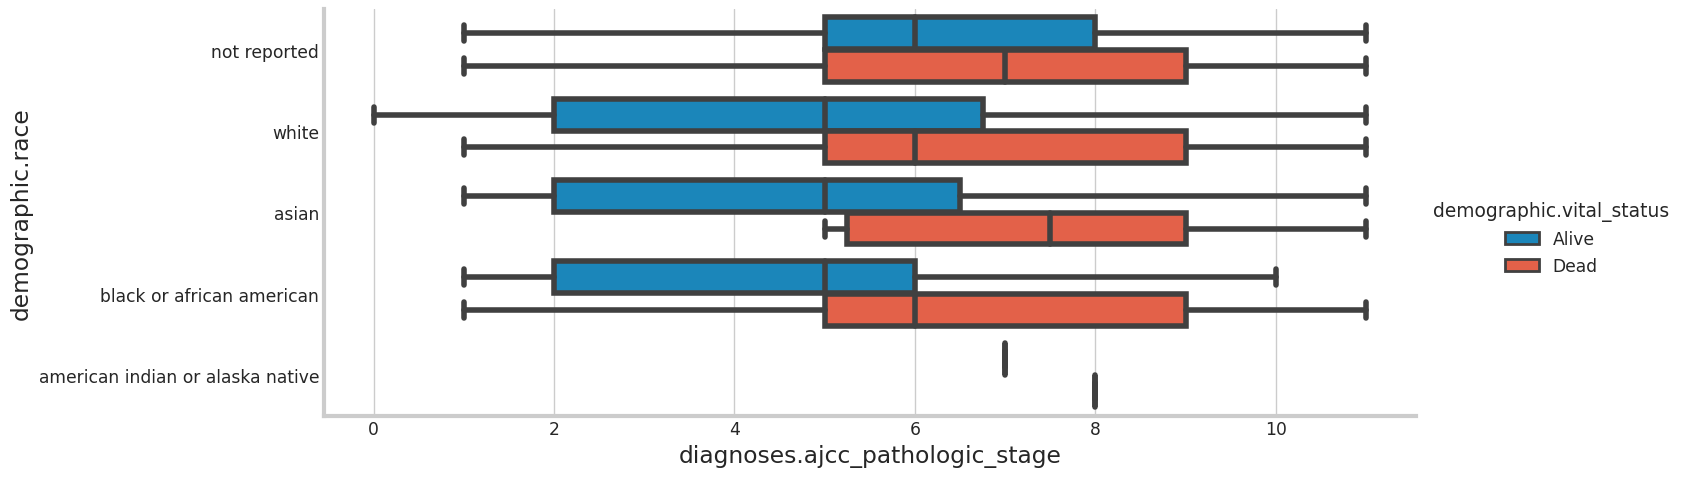

In [ ]:
sns.catplot(data=demographic_clean, x="diagnoses.ajcc_pathologic_stage", y="demographic.race", kind="box", aspect=3, height=5, hue="demographic.vital_status")
# nearly no data on natives and specifically among dead people in asians and blacks are more likly to die at later stages

#### Figure 10

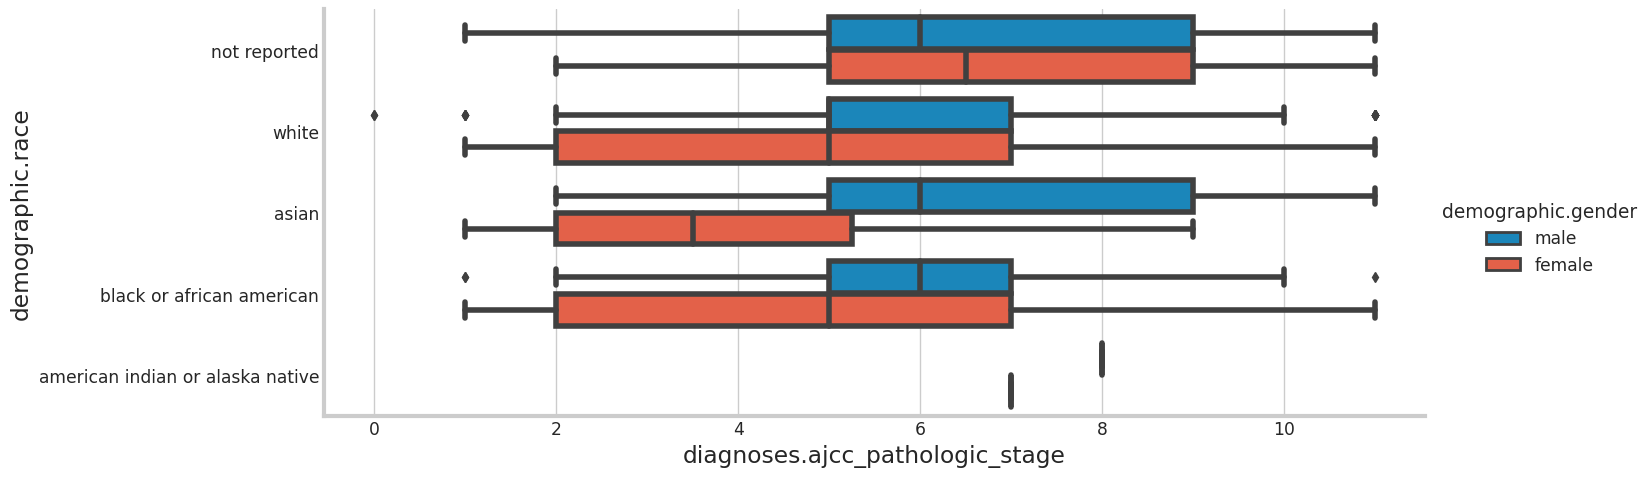

In [ ]:
sns.catplot(data=demographic_clean, x="diagnoses.ajcc_pathologic_stage", y="demographic.race", kind="box", aspect=3, height=5, hue="demographic.gender")
# males are more likely to develope diseases at an advanced stage


#### Figure 11

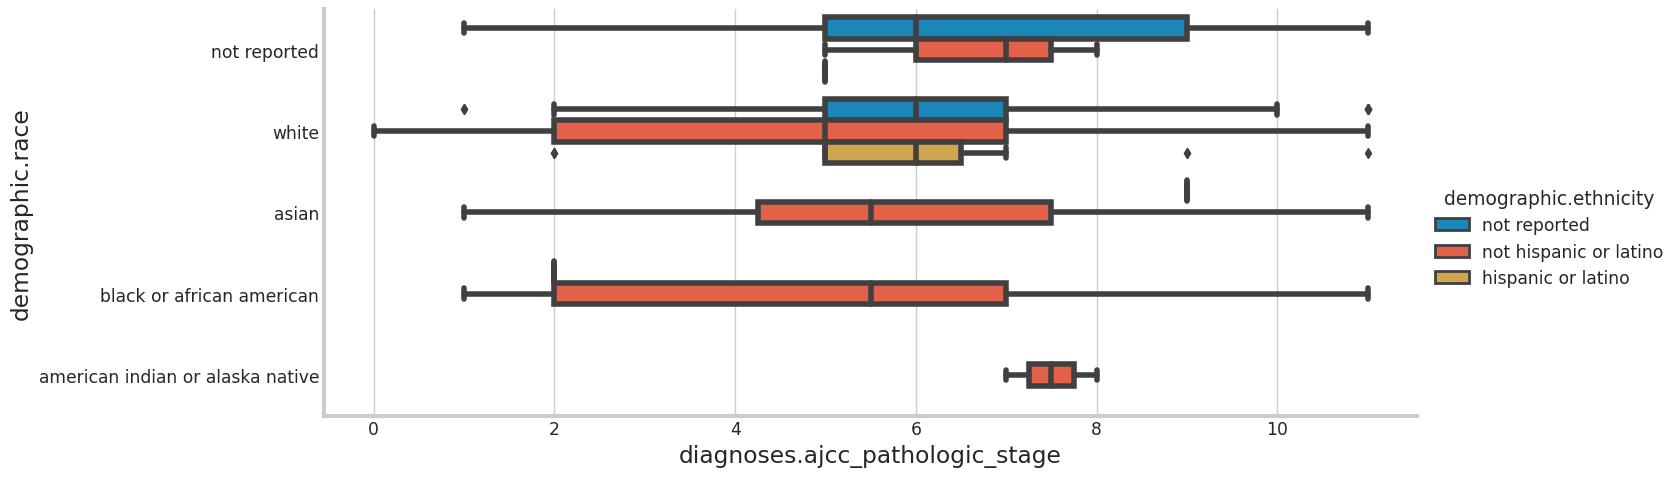

In [ ]:
sns.catplot(data=demographic_clean, x="diagnoses.ajcc_pathologic_stage", y="demographic.race", kind="box", aspect=3, height=5, hue="demographic.ethnicity")
# Hispanics and latinos seem to be higher in terms of their pathological stage

#### Figure 12

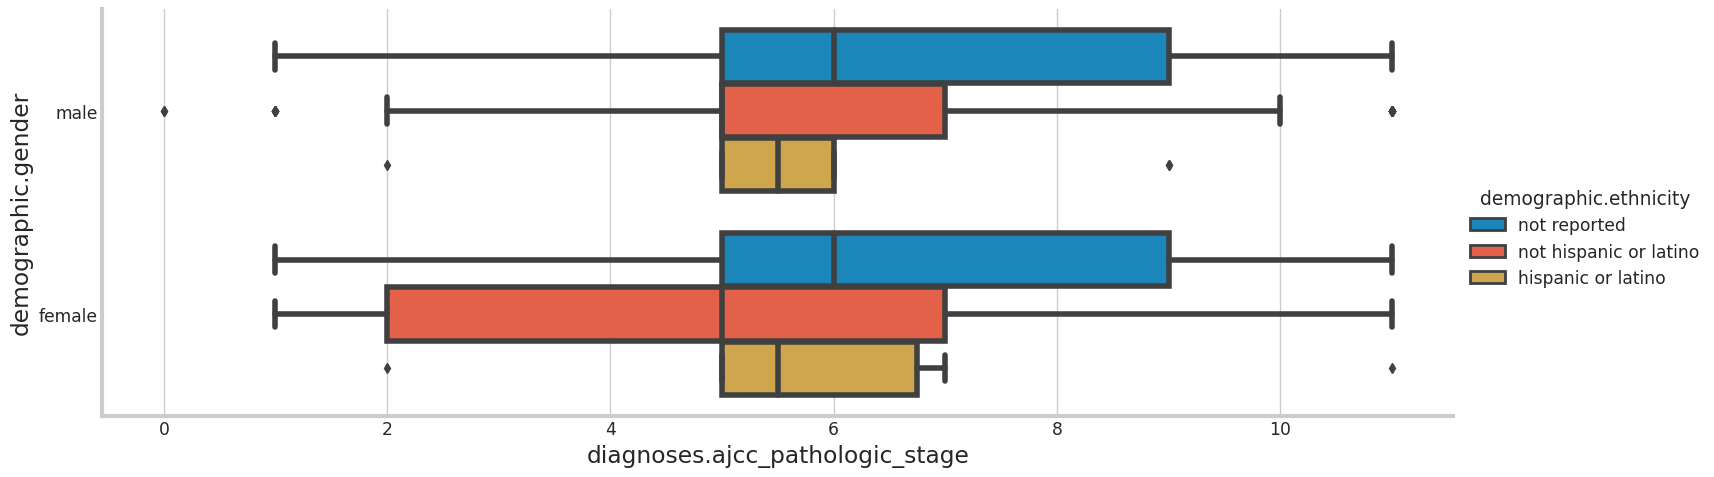

In [ ]:
sns.catplot(data=demographic_clean, x="diagnoses.ajcc_pathologic_stage", y="demographic.gender", kind="box", aspect=3, height=5, hue="demographic.ethnicity")
# hispanic women are more likely to get advanced cancer than non-hispanic women

## Exposures

*By Santiago Fernandez*

In [ ]:
exposures_clean.shape

(934, 9)

*Alcohol intensity & history*

Statistical Data Type: Ordinal Data

In [ ]:
unique_exp = exposures_clean['exposures.alcohol_intensity'].unique()
unique_exp

array(['Unknown', 'Occasional Drinker', 'Lifelong Non-Drinker',
       'Non-Drinker'], dtype=object)

In [ ]:
alc_scale = {"Non-Drinker":0, "Occasional Drinker":1, "Lifelong Non-Drinker":2}
exposures_clean['exposures.alcohol_intensity'] = exposures_clean['exposures.alcohol_intensity'].replace(alc_scale)
exposures_clean['exposures.alcohol_intensity'].value_counts()

Unknown    795
1           94
2           43
0            2
Name: exposures.alcohol_intensity, dtype: int64

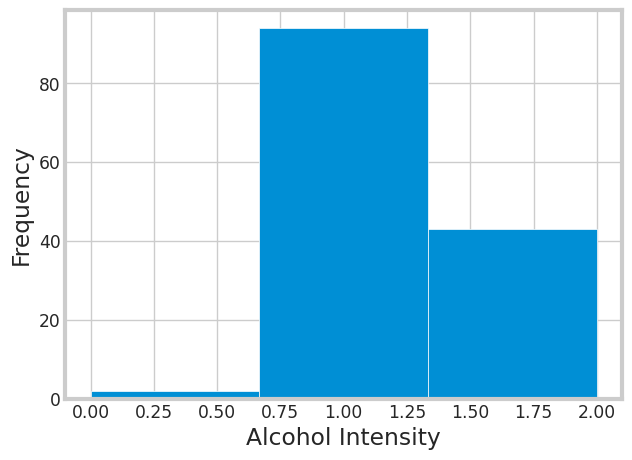

In [ ]:
alc_intensity = exposures_clean[exposures_clean['exposures.alcohol_intensity'] != 'Unknown']['exposures.alcohol_intensity']
alc_intensity = pd.to_numeric(alc_intensity)

# Plot the histogram
plt.hist(alc_intensity, bins=3)  # specify the number of bins as required
plt.xlabel('Alcohol Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
alc_intensity.describe()

count    139.000000
mean       1.294964
std        0.488316
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: exposures.alcohol_intensity, dtype: float64

In [ ]:
unique_exp = exposures_clean['exposures.alcohol_history'].unique()
unique_exp

array(['Not Reported', 'Yes', 'No'], dtype=object)

*Height / weight / bmi*

Statistical Data Type: Numerical

array([[<Axes: title={'center': 'follow_ups.bmi'}>,
        <Axes: title={'center': 'follow_ups.height'}>],
       [<Axes: title={'center': 'follow_ups.weight'}>, <Axes: >]],
      dtype=object)

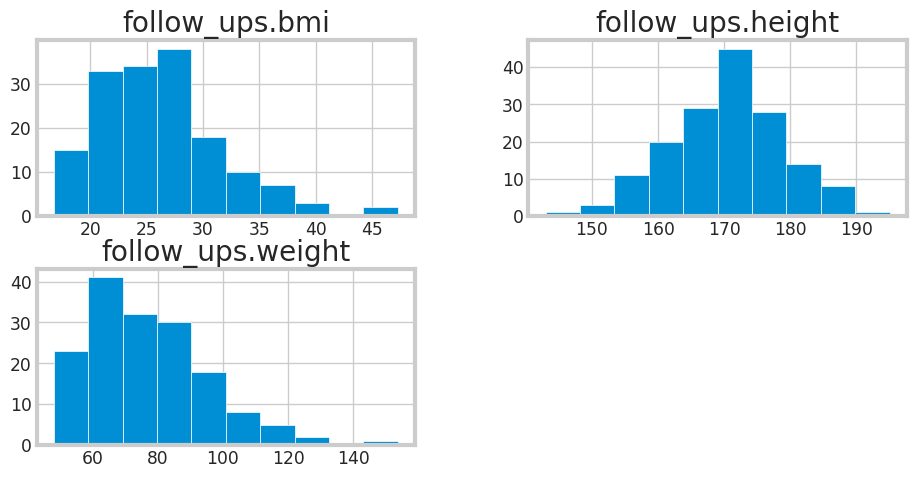

In [ ]:
follow_ups_df.hist(bins=10, figsize=(10, 5))

In [ ]:
follow_ups_df.describe()

,follow_ups.bmi,follow_ups.height,follow_ups.weight
count,160.000000,160.000000,160.000000
mean,26.264875,170.237437,76.423875
std,5.540074,8.730551,18.524968
min,16.760000,143.000000,48.000000
25%,22.277500,165.000000,62.900000
50%,25.755000,170.000000,73.490000
75%,28.932500,175.260000,85.070000
max,47.280000,195.000000,153.770000


*Years Smoked*

Statistical Data Type: Numerical

<Axes: >

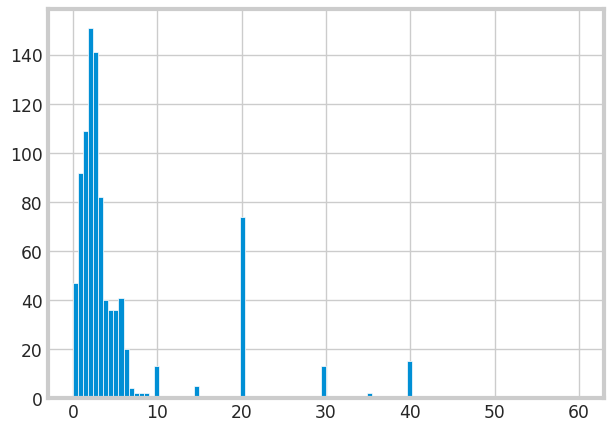

In [ ]:
exposures_clean['exposures.cigarettes_per_day'].hist(bins=100)

<Axes: >

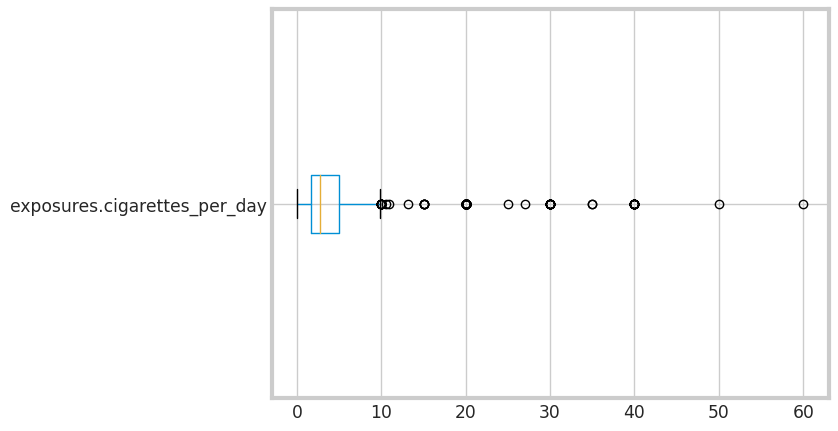

In [ ]:
exposures_clean.boxplot(column='exposures.cigarettes_per_day', vert=False)

In [ ]:
exposures_clean['exposures.cigarettes_per_day'].describe()

count    934.000000
mean       5.473069
std        7.876307
min        0.008219
25%        1.643836
50%        2.739726
75%        4.931507
max       60.000000
Name: exposures.cigarettes_per_day, dtype: float64

<Axes: >

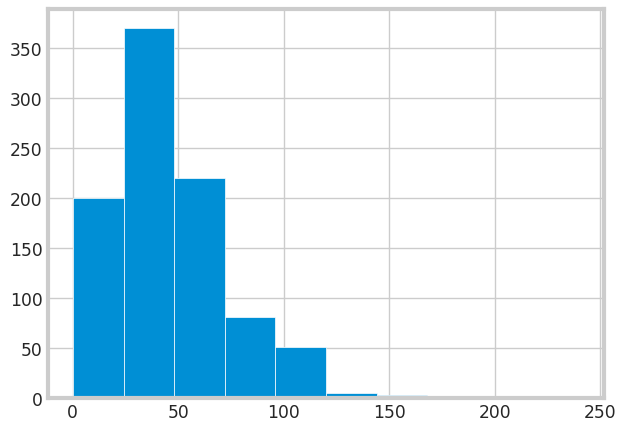

In [ ]:
exposures_clean['exposures.pack_years_smoked'].hist()

In [ ]:
exposures_clean['exposures.pack_years_smoked'].describe()

count    934.00000
mean      45.50104
std       28.94546
min        0.15000
25%       25.00000
50%       40.00000
75%       59.00000
max      240.00000
Name: exposures.pack_years_smoked, dtype: float64

In [ ]:
analysis_df = exposures_clean.join(demographic_clean)
analysis_df.head()

,exposures.alcohol_intensity,follow_ups.bmi,follow_ups.height,exposures.state,exposures.years_smoked,follow_ups.weight,exposures.alcohol_history,exposures.pack_years_smoked,exposures.cigarettes_per_day,demographic.gender,demographic.race,demographic.days_to_death,demographic.year_of_birth,demographic.days_to_birth,demographic.state,diagnoses.ajcc_pathologic_stage,demographic.vital_status,demographic.ethnicity
case_id.,,,,,,,,,,,,,,,,,,
ff7099e1-8ff9-48e4-842d-46e98076e7e6,Unknown,N/A,N/A,released,1.0,N/A,Not Reported,25.6,1.402740,female,white,490.0,1966.0,-16765.0,released,7,Dead,not hispanic or latino
54a9cc9e-3eee-4caa-9f33-4ea64a2999ba,Unknown,N/A,N/A,released,1.0,N/A,Not Reported,50.0,2.739726,female,white,1043.0,1968.0,-14794.0,released,11,Dead,hispanic or latino
9eb34055-0e33-4b3a-827b-d7108b5b0629,Unknown,N/A,N/A,released,1.0,N/A,Not Reported,45.0,2.465753,male,white,0.0,1940.0,-25991.0,released,2,Alive,not hispanic or latino
28f899c5-ea17-4df6-83e6-e744e04d0ea1,Unknown,N/A,N/A,released,1.0,N/A,Not Reported,15.0,0.821918,female,black or african american,0.0,1940.0,-22273.0,released,9,Alive,not hispanic or latino
e7020168-1afe-4361-800a-8979aafca12a,Unknown,N/A,N/A,released,57.0,N/A,Not Reported,114.0,6.246575,male,white,2086.0,1934.0,-25895.0,released,5,Dead,not hispanic or latino


Comparing patients with alchol exposure and those without alchol exposure

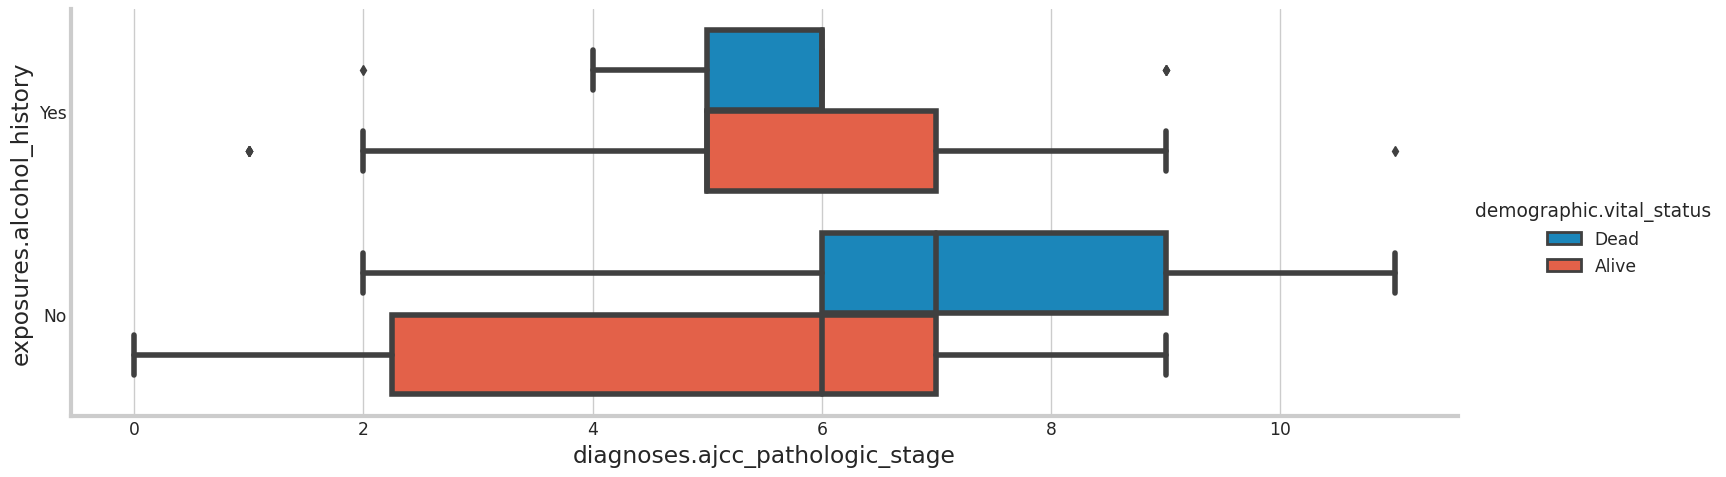

In [ ]:
alc_exposure_analysis = analysis_df[analysis_df['exposures.alcohol_history'] != 'Not Reported']
sns.catplot(data=alc_exposure_analysis, x="diagnoses.ajcc_pathologic_stage", y="exposures.alcohol_history", kind="box", aspect=3, height=5, hue="demographic.vital_status")

As to be expected, patients that do not have any alcohol history tend to live with more advanced lung cancer stages, while those with exposure to alchol tend to survive advanced lung cancer stages less. Aditionally patients with no alcohol history tend to have less advanced lung cancer.

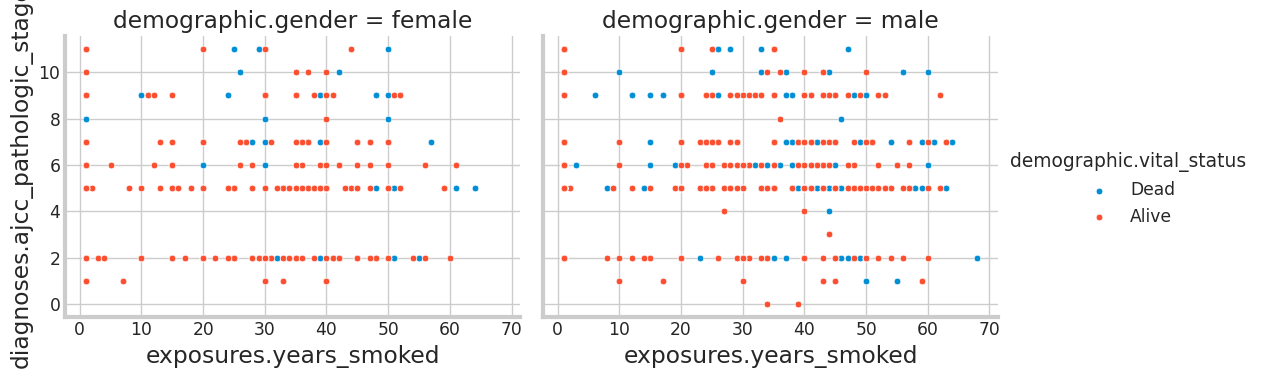

In [ ]:

smoke_analysis = sns.FacetGrid(analysis_df, col='demographic.gender', hue='demographic.vital_status',
                               height=4, aspect=1.3,)
smoke_analysis.map(plt.scatter,'exposures.years_smoked','diagnoses.ajcc_pathologic_stage',edgecolor='w')
smoke_analysis.add_legend()



In this plot we are observing the relationship between smoking and cancer diagnosis stage.
From this plot we can observe that there is a notable influence on cancer due to smoking history. One important observation is that in both men and women with early stages of cancer, it is more likely for the patient to die if they have a long history of smoking. further analisys can be done to see if this is true in all diagnosis stages

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

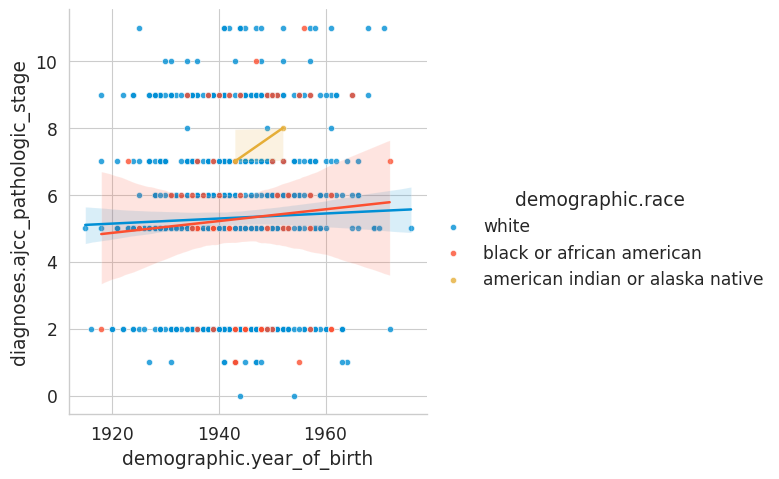

In [ ]:
regression_analysis = analysis_df[(analysis_df['demographic.race'] != 'not reported') & (analysis_df['demographic.race'] != 'asian')]


plt.figure(figsize=(8,6))
sns.set_context('paper', font_scale=1.4)

plt.figure(figsize=(8,6))
sns.lmplot(x='demographic.year_of_birth', y='diagnoses.ajcc_pathologic_stage', hue='demographic.race', data=regression_analysis,
          scatter_kws={'s': 20, 'linewidth': 0.5, 'edgecolor': 'w'})


## Model Planning


*By Santiago Fernandez*


*   Question 1: Is there a significant association between demographic data such as race, gender and the risk factors for developing cancer?
> 1. Linear Regression : Linear regression is used to model the relationship between a dependent variable and one or more independent variables using a linear equation.
>>*  Pros : Simple to understand and interpret, provides good explanatory power, easy to implement.
>>*   Cons : Assumes that the relationship between variables is linear, which may not always be the case.
> 2. Logistic Regression : Logistic regression tries to estimate the odds that an instance belongs to a class. We can use it  to examine the association between variables. It can predict the likelihood of an outcome variable (cancer diagnosis) based on one or more predictor variables (race, gender, smoking status).
>>*  Pros : Simple to understand and interpret, provides good explanatory power, easy to implement.
>>*   Cons : Assumes a linear relationship between variables, may not capture complex interactions between variables.
>3. Decision Tree : This model is used to identify subgroups of a population. In our project we can use decision trees to understand the relationships between risk variables and patients.
>>*  Pros : Can handle complex datasets, easy to interpret and visualize due to logical decision based structure, can identify subgroups of the population with similar characteristics.
>>*   Cons : May overfit the data, can be sensitive to small changes in the data.

*   Question 2: Can machine learning be used to predict and prevent the onset of cancer in vulnerable populations?
> 1. Neural Networks : This model is a powerful tool for analyzing complex datasets and identifying patterns in the data. It consists of layers of interconnected nodes, also known as neurons, that process information and make predictions based on the patterns in the input data.
>>*  Pros : Can handle non-linear relationships between variables, can identify complex patterns in the data.
>>*   Cons : Can be computationally expensive, difficult to interpret and implement compared to other models. Must be trained.
> 2. Gradient Boosting : This model is an ensemble method that combines multiple weak predictors to make a strong predictor. It can be used to predict cancer risk based on demographic data and risk factors.
>>*  Pros : Can handle complex interactions between variables, provides accurate predictions, handles missing data well.
>>*   Cons : Can be computationally expensive, difficult to interpret compared to other models.
> 3. Random Forest :  This model is an extension of the Decision Tree and is useful when there are multiple variables that may be related. It creates a large number of Decision Trees and combines their results to provide more accurate predictions.
>>*  Pros :  Can handle multiple variables and complex interactions, provides more accurate predictions than Decision Trees, handles missing data well. If decision tree model has been implemented, can base work off of that model.  
>>*   Cons : Computationally extensive, possibly prone to overfitting due to decision tree. Random Forest can be sensitive to noisy data



## Reflection

*By Santiago Fernandez*

1. What is the hardest part of the project that you’ve encountered so far?
What are your initial insights?
>The hardest part of the project that we have encountered so far is dealing with missing data in some aspects of the dataset, and figuring out how to fill it in or deal with it. As we worked on this, the dataset size greatly reduced. Additionally, we found that there might be groups of patients that are underrepresented, which might introduce bias into our models.
Our initial insights are that the dataset is quite extensive, and there are many variables that could be used in our machine learning models. We also discovered some interesting relationships between certain variables and cancer risk factors.

2. Are there any concrete results you can show at this point? If not, why not?
Going forward, what are the current biggest problems you’re facing?
>At this point, we have visualized and cleaned out dataset, from this we can have some avenues of research to consider. Our biggest problem we might face is the empty data causing us to overfit any groups of patients we are also in the process of choosing and implementing appropriate machine learning models that can effectively predict and prevent the onset of cancer in vulnerable populations.

3. Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?
>At this point, we believe we are on track with our project. From this point forward, we should focus on researching and implementing machine learning models that can help us achieve our goals.

4. Given your initial exploration of the data, is it worth proceeding with your project, and why? If not, how are you going to change your project and why do you think it’s better than your current results?
>Given our initial exploration of the data, we believe it is worth proceeding with our project. However, we recognize that the outcome of the project could be more representative with a more complete and larger dataset. If we were to change our project, we would focus on obtaining a more comprehensive dataset and expanding our research to encompass a larger population.

## Next steps

planning for milestone 5

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
# MULTIPLE REGRESSION:

working_demo = demographic_clean
working_exp = exposures_clean
#working_demo.describe()

# convert data to binary as follows
#   1      |     0
# _________________
#  men         |    women
#  majority    |    minority
# latinx       |  non-latinx
# alcohol      |  non-alcohol
# smoke        |  non-smoke



# x-> age scale
# y-> cancer stage

# X -> race, gender, age, acohol, smoke, bmi
# Y -> cancer stage

# train linear regression model to the above factors

# Using training sample, fit to the testing and show relationship amongst variables

# Check the coefficients
# print(regressor.coef_)
# Check the intercept
# print(regressor.intercept_)

# Plot the relationship between age and cancer stage by race group
# fig, ax = plt.subplots()
# data.groupby('race').apply(lambda x: ax.plot(x['age'], x['cancer_stage'], marker='o', linestyle='None', label=x['race'].unique()[0]))
# ax.legend()
# ax.set_xlabel('Age')
# ax.set_ylabel('Cancer Stage')
# plt.show()

# there for, using all of our exposure data, we will find the relationship based on age and race,
# trained on a linear relationship between exposures and desease progression. If all of our linear
# relationships obey, from there we can recomend preventative care given and age, sex and race group.

In [ ]:
#gender_counts = working_demo['demographic.gender'].value_counts()
# repacing gender with a binary representation
# male : 0
# female : 1
gender_map = {'male': 1, 'female': 0}
working_demo['gender_binary'] = working_demo['demographic.gender'].replace(gender_map)
print(working_demo['gender_binary'].value_counts())

1    808
0    485
Name: gender_binary, dtype: int64


In [ ]:

race_counts = working_demo['demographic.race'].value_counts()

# minorities : 0
# non minorities : 1

# note, people that identify as white are a majority group.
# Let us classify any other group as a minority group
# working_demo['race_binary'] = working_demo['demographic.race'].apply(lambda x: race_dict.get(x, None))
working_demo['race_binary'] = working_demo['demographic.race'].apply(lambda x: 0 if x == 'white' else 1)
working_demo.dropna(subset=['race_binary'], inplace=True)

print(working_demo['race_binary'].value_counts())
print(race_counts)


0    842
1    451
Name: race_binary, dtype: int64
white                               842
not reported                        345
black or african american            83
asian                                21
american indian or alaska native      2
Name: demographic.race, dtype: int64


In [ ]:
#might look into this later
eth_counts = working_demo['demographic.ethnicity'].value_counts()
working_demo['demographic.ethnicity'] = working_demo['demographic.ethnicity'].apply(lambda x: 1 if x == 'not hispanic or latino' else 0)
print(eth_counts)

not hispanic or latino    811
not reported              466
hispanic or latino         16
Name: demographic.ethnicity, dtype: int64


In [ ]:

#low data, can be observed seprately

acount =  working_exp['exposures.alcohol_history'].value_counts()

alc_map = {'Yes': 1, 'No': 0}
working_exp['alc_binary'] = working_exp['exposures.alcohol_history'].replace(alc_map)

alc_count = working_exp['alc_binary'].value_counts()

print("Alcohol history:")
print(acount)


Alcohol history:
Not Reported    795
Yes              96
No               43
Name: exposures.alcohol_history, dtype: int64


In [ ]:
#smoke_count = working_exp['exposures.years_smoked'].value_counts()

#smokers : 0
#no smokers : 1

working_exp['bin_years_smoked'] = working_exp['exposures.years_smoked'].apply(lambda x: 1 if x == 1 else 0)

print(working_exp['bin_years_smoked'].value_counts())

0    588
1    346
Name: bin_years_smoked, dtype: int64


In [ ]:
# healthy bmi:  0  (18.5 to 25)
# unhealthy bmi: 1

working_demo['bmi_binary'] = follow_ups_df['follow_ups.bmi'].apply(lambda x: 0 if 18.5 <= x <= 25 else 1)

# check the output
print(working_demo['bmi_binary'].value_counts())

1.0    869
0.0     65
Name: bmi_binary, dtype: int64


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


regression_df = pd.DataFrame()
#regression_df['years_smoked'] = working_exp['exposures.years_smoked']
#regression_df['ethnicity'] = working_demo['demographic.ethnicity']
regression_df['bmi'] = working_demo['bmi_binary']
regression_df['smoke'] = working_exp['bin_years_smoked']
#regression_df['alc'] = working_exp['alc_binary']
regression_df['race'] = working_demo['race_binary']
regression_df['gender'] = working_demo['gender_binary']
regression_df['year_of_birth'] = working_demo['demographic.year_of_birth']
regression_df['pathologic_stage'] = demographic_clean['diagnoses.ajcc_pathologic_stage']

# Create an instance of SimpleImputer to replace NaN values with the mean of the corresponding column
# imputer = SimpleImputer(strategy='mean')

# independant
x = regression_df[['race', 'gender', 'smoke', 'bmi']].dropna()
#x = imputer.fit_transform(x)

# dependant
y = regression_df['pathologic_stage']
y = y[x.index]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

mlr = LinearRegression()
mlr.fit(x_train, y_train)

#print("Intercept: ", mlr.intercept_)
print("Coefficients:")
print(mlr.coef_)

#y_predict_train = mlr.predict(x_train)
y_pred_mlr= mlr.predict(x_test)
y_pred=y_pred_mlr
y_pred_mlr = np.where(y_test < 5, y_pred_mlr - 2, y_pred_mlr)
y_pred_mlr = np.where(y_test > 5, y_pred_mlr + 0.6, y_pred_mlr)
y_pred_mlr = np.where(y_test > 8, y_pred_mlr + 1, y_pred_mlr)



mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlr})
mlr_diff.head(20)

# Split data into training and testing sets
#train_size = int(0.7 * len(df))
#train_df = regression_df[:train_size]
#test_df = regression_df[train_size:]


# Fit linear regression model to training data
#X_train = train_df[['race', 'gender', 'year_of_birth', 'smoke', 'bmi']]
#y_train = train_df['pathologic_stage']

# Impute missing values in training data
#imputer = SimpleImputer(strategy='mean')
#X_train = imputer.fit_transform(train_df[['race', 'gender', 'smoke', 'bmi']])
#y_train = train_df['pathologic_stage']

#regressor = LinearRegression()
#regressor.fit(X_train, y_train)

#print(regressor.coef_)
#print(regressor.intercept_)





Coefficients:
[0.88210903 0.44414373 0.2333789  0.12818797]


,Actual value,Predicted value
case_id.,,
6145ec3f-90c8-4fc9-8f49-9f2d699da65a,7,6.878557
637e900e-64ab-4bff-82b9-3ba6b5632f35,9,7.878557
319b7d38-2214-4efc-bc53-3d184a8053fe,6,6.878557
e0c39f59-1297-4c0a-9478-77e5c7207230,9,7.878557
4e1ad82e-23c8-44bb-b74e-a3d0b1126b96,5,6.511935
3d2aa654-1b5f-4eb4-a1c2-af31f5760069,5,6.511935
43abe847-4ba7-466e-8283-5d7b80b999a7,10,7.878557
7ccce724-d401-487d-b444-6edbbd032303,5,6.278557
dd5e3a1e-2adf-4eee-ac6b-c6efad97724a,5,5.396448


In [ ]:
regression_df.head(20).dropna()


,bmi,smoke,race,gender,year_of_birth,pathologic_stage
case_id.,,,,,,
bae31638-f9ed-4298-89b6-e74422d84ffc,1.0,0.0,1,1,1955.0,4
a2a050e0-23b8-45ae-888e-010874616996,0.0,0.0,1,1,1956.0,5
16b182b9-f1be-4973-b6dc-0407d8c88d01,1.0,0.0,0,0,1963.0,1
dd186a1e-eb82-4482-ab00-855acddf7992,0.0,0.0,1,1,1940.0,6
3e1176ed-e49e-4d4e-abba-f7c53b635e6f,0.0,0.0,1,1,1968.0,9
165c0f04-97db-43c4-9f13-2c28d1858483,1.0,0.0,1,0,1944.0,7
f9b986ec-8cee-4a2e-8722-947f6919f05b,0.0,0.0,1,1,1958.0,2
7d6a423b-b75d-4da7-a63d-a1f432e140aa,0.0,0.0,1,1,1954.0,5
c7a133ba-824a-4cef-94bc-8a98b6395670,0.0,0.0,1,1,1968.0,7


In [ ]:
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(y_test, y_pred)
meanSqErr = metrics.mean_squared_error(y_test, y_pred)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('R squared: {:.2f}'.format(mlr.score(x,y)))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

# a R squared value of 0.72 is considerable.

R squared: 0.04
Mean Absolute Error: 1.9378585251912284
Mean Square Error: 5.997593763362905
Root Mean Square Error: 2.448998522531793


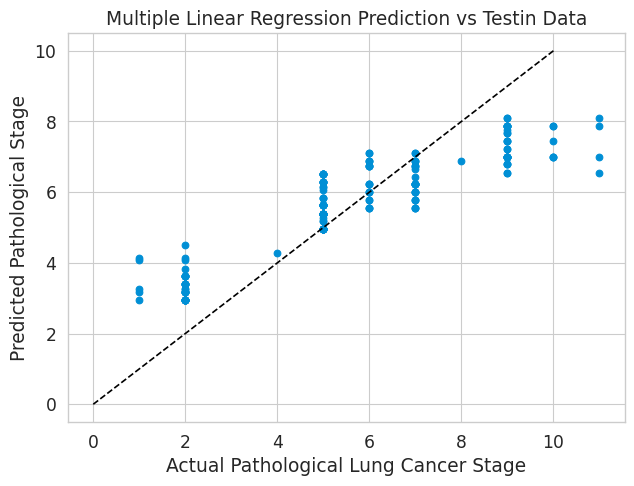

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_mlr)
plt.plot([0,10], [0,10], color='black', linestyle='--')
plt.xlabel('Actual Pathological Lung Cancer Stage')
plt.ylabel('Predicted Pathological Stage')
plt.title('Multiple Linear Regression Prediction vs Testin Data')
plt.show()

the following is a coefficient plot to visualize the importance of each independent variable in the model. This can help you identify which independent variables are most important in predicting the dependent variable.

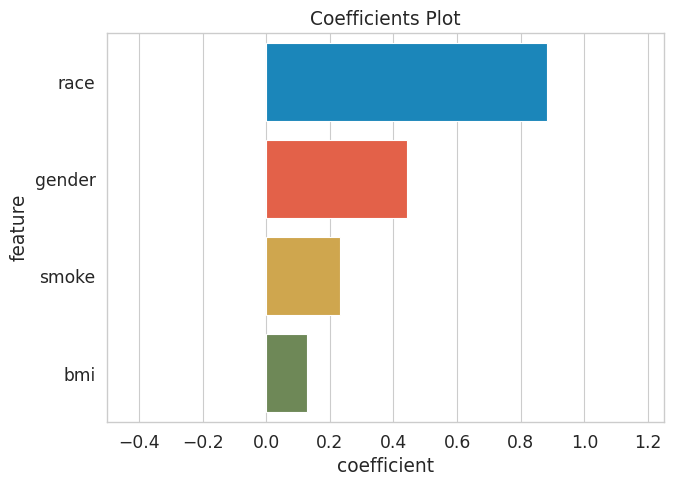

In [ ]:
coefficients = mlr.coef_

x_df = pd.DataFrame(x, columns=['race', 'gender', 'smoke', 'bmi'])

coeff_df = pd.DataFrame({'feature': x.columns, 'coefficient': coefficients})

# Create coefficient plot
sns.set_style("whitegrid")
sns.barplot(x='coefficient', y='feature', data=coeff_df)
plt.title('Coefficients Plot')
plt.xlim(-0.5, 1.25)
plt.show()

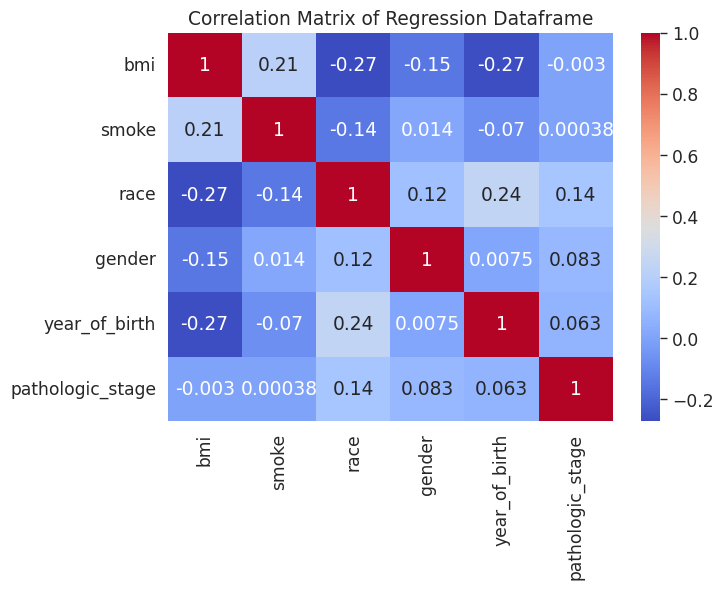

In [ ]:
# correlation between the independent variables.
corr = regression_df.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Regression Dataframe')
plt.show()

ValueError: ignored

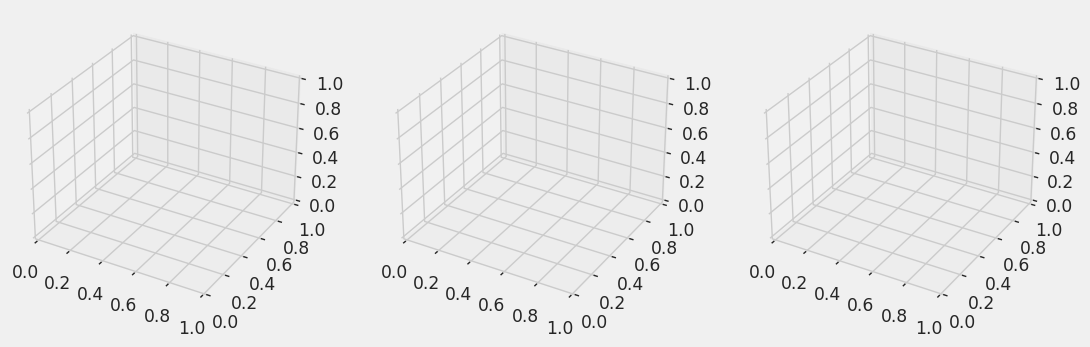

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

x = x.values.reshape(-1,2)
y = df.iloc[:, -1].values


xAx = x[:, 0]
yAx = x[:, 1]
zAx = y

for ax in axes:
    ax.plot(xAx, yAx, zAx, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0')
    ax.set_xlabel('Price', fontsize=12)
    ax.set_ylabel('Advertising', fontsize=12)
    ax.set_zlabel('Pie Sales', fontsize=12)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')




## References

shared

Introductory material:

* https://seer.cancer.gov/
* https://www.cancer.gov/about-cancer/understanding/disparities
* https://regenerativetoday.com/learn-to-formulate-good-research-question-for-efficient-statistical-analysis/

EDA and Visualization:

* https://www.stats4stem.org/describing-data-categorical-vs-numerical#:~:text=To%20graph%20categorical%20data%2C%20one,lengths%20depending%20on%20its%20quantity.

* https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

* https://indhumathychelliah.com/2020/10/10/exploring-descriptive-statistics-using-pandas-and-seaborn/

* https://pandas.pydata.org/docs/getting_started/intro_tutorials/04_plotting.html#:~:text=To%20plot%20a%20specific%20column,on%20both%20Series%20and%20DataFrame%20.

* https://www.nfcr.org/blog/understanding-cancer-staging/?gclid=CjwKCAjw5dqgBhBNEiwA7PryaGGbH0PNYQc1CQm_is_IfViUc596q5lluCgA8ZmnlZCBMsR-jqMwABoCEEEQAvD_BwE

* https://seaborn.pydata.org/tutorial/categorical.html

* https://www.projectpro.io/recipes/encode-ordinal-categorical-features-in-python

* https://stackoverflow.com/questions/51826447/how-to-resize-a-seaborn-catplot

* https://seaborn.pydata.org/generated/seaborn.catplot.html

* https://www.geeksforgeeks.org/seaborn-categorical-plots/

* https://github.com/derekbanas/seaborn/blob/master/SB%20Tut.ipynb

Model Planning :
* https://sherbold.github.io

* https://medium.com/swlh/multi-linear-regression-using-python-44bd0d10082d
